![qqq](../resources/header.jpg)

**Машинное обучение**
***

О сайте **Backloggd.com**:

"**Backloggd** — это место для хранения вашей личной коллекции видеоигр. Каждая игра со всех платформ доступна для вас, чтобы вы могли войти в свой журнал. Следуйте за друзьями, чтобы поделиться своими отзывами и сравнить рейтинги. Затем используйте фильтры, чтобы отсортировать свою коллекцию и посмотреть, что для вас важно. Ведите список того, во что вы сейчас играете и во что хотите играть, и наблюдайте, как цифры меняются по мере того, как вы продолжаете записывать свои прохождения. Есть Goodreads для книг, Letterboxd для фильмов и теперь Backloggd для игр.

Все метаданные, связанные с игрой, поступают из базы данных **[IGDB](https://www.igdb.com/)**, управляемой сообществом . Сюда входят все данные об играх, компаниях и платформах, которые вы видите на сайте." - с сайта **[backloggd.com](https://www.backloggd.com/)**.

**Цель машинного обучения**: на основе подготовленных и предварительно обработанных данных,  обуитье модеьи, предсказываюуюй игровые жанры,к к которым принадлежит видеоигра с заданным описание    Выраатьтка сисуемы по оценке эффективности модели.

**Этапы машинного обучения**:
1. [Обзор данных](#Обзор-данных).
2. [Предобработка данных](#Предобработка-данных)
3. [Машинное обучение](#Машинное-обучение):
    - [Отбор данных](#Отбор-данных);
    - [Анализ баланса классов](#Анализ-баланса-классов);
    - [Предобработка текста](#Предобработка-текста);
    - [Разделение на выборки](#Разделение-на-выборки)
    - [Тестирование моделей](#Тестирование-моделей)
        - [Тестирование ComplementNB](#Тестирование-ComplementNB)
        - [Тестирование SGDClassifier](#Тестирование-SGDClassifier)
        - [Выводы по тестированию моделей](#Выводы-по-тестированию-моделей)
    - [Генерация признаков](#Генерация-признаков)
        - [ComplementNB](#ComplementNB)
        - [SGDClassifier](#SGDClassifier)
        - [Выводы по генерации признаков](#Выводы-по-генерации-признаков)
    - [Проверка модели на тестовой выборке](#Проверка-модели-на-тестовой-выборке)
4. [Выводы](#Выводы)
***

In [1]:
import sys

In [2]:
sys.path.append('C:\Projects\Backloggd')
sys.path.append('C:\Projects\Backloggd\src')

In [3]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MultiLabelBinarizer

from config.ml import FIT_CV_SPLITTING_STRATEGY
from config.ml import FIT_CV_VERBOSE
from config.ml import LEARNING_CURVE_SPLITTING_STRATEGY_N_SPLITS
from config.ml import LEARNING_CURVE_SPLITTING_STRATEGY_TEST_SIZE
from config.ml import LEARNING_CURVE_SPLITTING_STRATEGY_TRAIN_SIZES
from config.ml import LEARNING_CURVE_VERBOSE
from config.ml import N_JOBS
from config.ml import RANDOM_STATE
from config.paths import PATH_PREPROCESSED_DATA
from utils.explorer import explorer
from utils.ml.plot import balance
from utils.ml.plot import calibration
from utils.ml.plot import metrics
from utils.ml.plot import scalability
from utils.ml.plot import words
from utils.ml.plot.step import step
from utils.ml.preprocessing import cleaning
from utils.ml.preprocessing import lemmatization
from utils.ml.preprocessing import stopwords

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gsimo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gsimo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gsimo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
sns.set_style('white')

In [5]:
RANDOM_STATE = 42

In [6]:
sns.set_style('white')

In [7]:
print(explorer(PATH_PREPROCESSED_DATA, exclude=('checkpoints', )))

1. backloggd.


In [8]:
folder = 'backloggd'

In [9]:
print(explorer(f'{PATH_PREPROCESSED_DATA}/{folder}', '*.csv'))

1. developers.csv.
2. games.csv.
3. genres.csv.
4. platforms.csv.
5. scores.csv.


In [10]:
file_paths ={
    'games': f'{PATH_PREPROCESSED_DATA}/{folder}/games.csv',
    'genres': f'{PATH_PREPROCESSED_DATA}/{folder}/genres.csv',
}

# Обзор данных
***

In [11]:
df = {file: pd.read_csv(path) for file, path in file_paths.items()}

In [12]:
df['games'].info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141741 entries, 0 to 141740
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           141741 non-null  int64  
 1   name         141741 non-null  object 
 2   date         120064 non-null  object 
 3   indie        141741 non-null  bool   
 4   rating       38949 non-null   float64
 5   votes        141741 non-null  int64  
 6   reviews      141741 non-null  int64  
 7   plays        141741 non-null  int64  
 8   playing      141741 non-null  int64  
 9   backlogs     141741 non-null  int64  
 10  wishlists    141741 non-null  int64  
 11  description  128451 non-null  object 
dtypes: bool(1), float64(1), int64(7), object(3)
memory usage: 80.7 MB


In [13]:
pd.concat([
    df['games'].head(),
    df['games'].sample(5),
    df['games'].tail()
])

,id,name,date,indie,rating,votes,reviews,plays,playing,backlogs,wishlists,description
0,1000001,Cathode Ray Tube Amusement Device,1947-12-31,False,3.529070,86,65,117,1,28,56,The cathode ray tube amusement device is the e...
1,1000002,Bertie the Brain,1950-08-25,False,2.535714,14,11,24,0,6,12,Currently considered the first videogame in hi...
2,1000003,Nim,1951-12-31,False,1.750000,6,2,11,0,2,6,The Nimrod was a special purpose computer that...
3,1000004,Draughts,1952-08-31,False,2.388889,9,3,17,0,3,7,A game of draughts (a.k.a. checkers) written f...
4,1000005,OXO,1952-12-31,False,3.066667,30,14,52,1,12,13,OXO was a computer game developed by Alexander...
55889,1063679,Pony City,2015-08-01,False,NaN,0,0,0,0,0,0,Pony City is a game for pony lovers where you ...
7850,1010343,Aero Fighters,1992-01-01,False,3.405473,201,23,341,2,56,32,There are eight stages in this game. The begin...
20761,1025408,Digimon Kari and Gatomon,2000-12-31,False,NaN,0,0,1,0,0,0,NaN
44221,1051172,MLB 12: The Show,2012-03-06,False,3.393939,33,4,53,0,3,1,MLB 12 The Show is the latest release in a fra...
125899,1144250,Mercenary Warriors,NaN,True,NaN,0,0,0,0,1,0,Mercenary Warriors is a Turn Based PVP Strateg...


In [14]:
df['genres'].info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198108 entries, 0 to 198107
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      198108 non-null  int64 
 1   genre   198108 non-null  object
dtypes: int64(1), object(1)
memory usage: 13.8 MB


In [15]:
pd.concat([
    df['genres'].head(),
    df['genres'].sample(5),
    df['genres'].tail()
])

,id,genre
0,1000001,Point-and-Click
1,1000002,Puzzle
2,1000002,Tactical
3,1000003,Pinball
4,1000003,Strategy
187540,1149174,Arcade
157156,1120188,Card & Board Game
24891,1022138,Sport
3131,1003094,Arcade
147570,1112988,Arcade


# Предварительная обработка данных

In [16]:
records = {name: data.shape[0] for name, data in df.items()}
records

{'games': 141741, 'genres': 198108}

## Обработка типов данных
***

In [17]:
index = pd.MultiIndex.from_arrays(
    arrays=[
        [name for name, data in df.items() for _ in range(len(data.dtypes))],
        [index for data in df.values() for index in data.dtypes.index]
    ],
    names=['Набор данных', 'Поля']
)
values = [value for data in df.values() for value in data.dtypes.values]
pd.DataFrame(
    data=values,
    index=index,
    columns=['Типы данных']
).style

Изменим типы данных:
- для поля **date** в наборе **games** изменим тип данных на **datetime**;
- для **числовых полей**, уменьшим точность до **32 бит**.

In [18]:
df['games']['date'] = pd.to_datetime(df['games']['date'], format='%Y-%m-%d')

In [19]:
df['games'] = df['games'].astype(
    {
        'votes': 'int32',
        'reviews': 'int32',
        'plays': 'int32',
        'playing': 'int32',
        'backlogs': 'int32',
        'wishlists': 'int32',
        'rating': 'float32'
    }
)

In [20]:
for name in df:
    df[name] = df[name].astype({'id': 'int32'})

In [21]:
index = pd.MultiIndex.from_arrays(
    arrays=[
        [name for name, data in df.items() for _ in range(len(data.dtypes))],
        [index for data in df.values() for index in data.dtypes.index]
    ],
    names=['Набор данных', 'Поля']
)
values = [value for data in df.values() for value in data.dtypes.values]
pd.DataFrame(
    data=values,
    index=index,
    columns=['Типы данных']
).style

## Обработка явных дубликатов
***

In [22]:
table = pd.DataFrame(
    data={
        'Количество': [data.duplicated().sum() for data in df.values()],
        'Проценты': [data.duplicated().sum() / records[name] for name, data in df.items()],
    },
    index=[data for data in df]
)
table.loc['Всего', :] = [table['Количество'].sum(),  
                         table['Количество'].sum() / 
                         sum([record for record in records.values()])]
table = table.astype({'Количество': 'int32'})
(table
 .style
 .format({'Проценты': lambda x: f'{x:.2%}'}))

,Количество,Проценты
games,0,0.00%
genres,0,0.00%
Всего,0,0.00%


## Анализ пустых записей
***

In [23]:
index = pd.MultiIndex.from_arrays(
    arrays=[
        [name for name, data in df.items() for _ in range(len(data.dtypes))],
        [index for data in df.values() for index in data.dtypes.index]
    ],
    names=['Набор данных', 'Поле']
)
values = {
    'Количество': [value for data in df.values() for value in data.isna().sum().values],
    'Проценты': [value / records[name] for name, data in df.items() for value in data.isna().sum().values],
}
(pd.DataFrame(
    data=values,
    index=index,
).style
 .format({'Проценты': lambda x: f'{x:.2%}'}))

# Машинное обучение
***

## Отбор данных
***

In [24]:
df['games']

,id,name,date,indie,rating,votes,reviews,plays,playing,backlogs,wishlists,description
0,1000001,Cathode Ray Tube Amusement Device,1947-12-31,False,3.529070,86,65,117,1,28,56,The cathode ray tube amusement device is the e...
1,1000002,Bertie the Brain,1950-08-25,False,2.535714,14,11,24,0,6,12,Currently considered the first videogame in hi...
2,1000003,Nim,1951-12-31,False,1.750000,6,2,11,0,2,6,The Nimrod was a special purpose computer that...
3,1000004,Draughts,1952-08-31,False,2.388889,9,3,17,0,3,7,A game of draughts (a.k.a. checkers) written f...
4,1000005,OXO,1952-12-31,False,3.066667,30,14,52,1,12,13,OXO was a computer game developed by Alexander...
...,...,...,...,...,...,...,...,...,...,...,...,...
141736,1172491,Slendrina: Asylum,NaT,False,NaN,1,0,2,1,0,0,Slendrina is back in a new scary adventure! S...
141737,1172495,HyperSpace: Pirates of Atira,NaT,False,NaN,0,0,0,0,0,1,HyperSpace : Pirates of Atira is a first perso...
141738,1172496,Die Hard 64,NaT,False,NaN,1,0,3,0,1,1,Die Hard 64 is a cancelled game for the Ninten...
141739,1172508,Super Robot Wars 30: Digital Deluxe Edition,NaT,False,NaN,0,0,0,0,0,0,NaN


Отберем только **описание видеоигр**.

In [25]:
data = df['games'].loc[:, ['id', 'description']].copy()
data

,id,description
0,1000001,The cathode ray tube amusement device is the e...
1,1000002,Currently considered the first videogame in hi...
2,1000003,The Nimrod was a special purpose computer that...
3,1000004,A game of draughts (a.k.a. checkers) written f...
4,1000005,OXO was a computer game developed by Alexander...
...,...,...
141736,1172491,Slendrina is back in a new scary adventure! S...
141737,1172495,HyperSpace : Pirates of Atira is a first perso...
141738,1172496,Die Hard 64 is a cancelled game for the Ninten...
141739,1172508,NaN


**Удалим** записи **без описания** видеоигр.

In [26]:
data = (data
        .loc[data['description'].notna(), :]
        .reset_index(drop=True))
data

,id,description
0,1000001,The cathode ray tube amusement device is the e...
1,1000002,Currently considered the first videogame in hi...
2,1000003,The Nimrod was a special purpose computer that...
3,1000004,A game of draughts (a.k.a. checkers) written f...
4,1000005,OXO was a computer game developed by Alexander...
...,...,...
128446,1172480,Game for Tomy Tutor platform.
128447,1172491,Slendrina is back in a new scary adventure! S...
128448,1172495,HyperSpace : Pirates of Atira is a first perso...
128449,1172496,Die Hard 64 is a cancelled game for the Ninten...


Отберем видеоигры, в описаниях которых присутствуют только **ascii символы**.

In [27]:
data = (data
        .loc[data['description'].apply(lambda x: x.isascii()), :]
        .reset_index(drop=True))
data

,id,description
0,1000001,The cathode ray tube amusement device is the e...
1,1000002,Currently considered the first videogame in hi...
2,1000003,The Nimrod was a special purpose computer that...
3,1000004,A game of draughts (a.k.a. checkers) written f...
4,1000007,Tennis for Two is often credited to be the wor...
...,...,...
113807,1172477,"A sequel to the original ""The Treasures of Mon..."
113808,1172480,Game for Tomy Tutor platform.
113809,1172491,Slendrina is back in a new scary adventure! S...
113810,1172496,Die Hard 64 is a cancelled game for the Ninten...


## Объединение данных

In [28]:
df['genres']

,id,genre
0,1000001,Point-and-Click
1,1000002,Puzzle
2,1000002,Tactical
3,1000003,Pinball
4,1000003,Strategy
...,...,...
198103,1172472,RPG
198104,1172477,Puzzle
198105,1172484,Racing
198106,1172496,Shooter


In [29]:
df['genres']['genre'].value_counts()

genre
Adventure              41451
Simulator              19104
RPG                    18798
Strategy               18144
Shooter                15820
Puzzle                 14792
Arcade                 12319
Platform               11861
Sport                   8642
Visual Novel            6846
Racing                  6099
Fighting                4305
Point-and-Click         3368
Brawler                 3114
Turn Based Strategy     2834
Card & Board Game       2552
Music                   2340
Tactical                2039
Real Time Strategy      1943
Quiz/Trivia             1107
Pinball                  516
MOBA                     114
Name: count, dtype: int64

Отберем только **20 самых популярных жанров**.

In [30]:
genres = df['genres']['genre'].value_counts().index[:20]
genres = (df['genres']
          .loc[df['genres']['genre'].isin(genres), :]
          .set_index('id'))['genre']
genres

id
1000001      Point-and-Click
1000002               Puzzle
1000002             Tactical
1000003             Strategy
1000004    Card & Board Game
                 ...        
1172472                  RPG
1172477               Puzzle
1172484               Racing
1172496              Shooter
1172511             Fighting
Name: genre, Length: 197478, dtype: object

In [31]:
genres.value_counts()

genre
Adventure              41451
Simulator              19104
RPG                    18798
Strategy               18144
Shooter                15820
Puzzle                 14792
Arcade                 12319
Platform               11861
Sport                   8642
Visual Novel            6846
Racing                  6099
Fighting                4305
Point-and-Click         3368
Brawler                 3114
Turn Based Strategy     2834
Card & Board Game       2552
Music                   2340
Tactical                2039
Real Time Strategy      1943
Quiz/Trivia             1107
Name: count, dtype: int64

**Объеденим** данные.

In [32]:
def insert(key: int, values: pd.Series) -> list:
    if key in values.index:
        value = values[key]
        return [value] if isinstance(value, str) else value.to_list()
    else:
        return []

In [33]:
data.insert(
    loc=data.shape[1],
    column='genres',
    value=data['id'].apply(insert, values=genres)
)
data = data.drop('id', axis=1)
data

,description,genres
0,The cathode ray tube amusement device is the e...,[Point-and-Click]
1,Currently considered the first videogame in hi...,"[Puzzle, Tactical]"
2,The Nimrod was a special purpose computer that...,[Strategy]
3,A game of draughts (a.k.a. checkers) written f...,[Card & Board Game]
4,Tennis for Two is often credited to be the wor...,"[Arcade, Sport]"
...,...,...
113807,"A sequel to the original ""The Treasures of Mon...",[Puzzle]
113808,Game for Tomy Tutor platform.,[]
113809,Slendrina is back in a new scary adventure! S...,[]
113810,Die Hard 64 is a cancelled game for the Ninten...,[Shooter]


Удалим записи **без жанров**.

In [34]:
data = (data
        .loc[data['genres'].map(bool), :]
        .reset_index(drop=True))
data

,description,genres
0,The cathode ray tube amusement device is the e...,[Point-and-Click]
1,Currently considered the first videogame in hi...,"[Puzzle, Tactical]"
2,The Nimrod was a special purpose computer that...,[Strategy]
3,A game of draughts (a.k.a. checkers) written f...,[Card & Board Game]
4,Tennis for Two is often credited to be the wor...,"[Arcade, Sport]"
...,...,...
97274,This is an additional character for Atelier Fi...,[RPG]
97275,"When you're falsely accused of sorcery, corrup...","[Adventure, RPG]"
97276,"A sequel to the original ""The Treasures of Mon...",[Puzzle]
97277,Die Hard 64 is a cancelled game for the Ninten...,[Shooter]


## Предобработка текста
***

**Очистим** описание от символов, отличных от символов **латинского алфавита**.

In [35]:
data['description'] = cleaning(data['description'])
data

,description,genres
0,the cathode ray tube amusement device is the e...,[Point-and-Click]
1,currently considered the first videogame in hi...,"[Puzzle, Tactical]"
2,the nimrod was a special purpose computer that...,[Strategy]
3,a game of draughts a k a checkers written for ...,[Card & Board Game]
4,tennis for two is often credited to be the wor...,"[Arcade, Sport]"
...,...,...
97274,this is an additional character for atelier fi...,[RPG]
97275,when you re falsely accused of sorcery corrupt...,"[Adventure, RPG]"
97276,a sequel to the original the treasures of mont...,[Puzzle]
97277,die hard is a cancelled game for the nintendo ...,[Shooter]


Проведем **лемматизацию** текста.

In [36]:
data['description'] = lemmatization(data['description'])
data

,description,genres
0,the cathode ray tube amusement device be the e...,[Point-and-Click]
1,currently consider the first videogame in hist...,"[Puzzle, Tactical]"
2,the nimrod be a special purpose computer that ...,[Strategy]
3,a game of draught a k a checker write for the ...,[Card & Board Game]
4,tennis for two be often credit to be the world...,"[Arcade, Sport]"
...,...,...
97274,this be an additional character for atelier fi...,[RPG]
97275,when you re falsely accuse of sorcery corrupt ...,"[Adventure, RPG]"
97276,a sequel to the original the treasure of monte...,[Puzzle]
97277,die hard be a cancel game for the nintendo dev...,[Shooter]


Отберем видеоигры, описания которых не состоят только **из пробельных символов**.

In [37]:
data = (data
        .loc[~data['description'].apply(lambda x: x.isspace()), :]
        .reset_index(drop=True))
data

,description,genres
0,the cathode ray tube amusement device be the e...,[Point-and-Click]
1,currently consider the first videogame in hist...,"[Puzzle, Tactical]"
2,the nimrod be a special purpose computer that ...,[Strategy]
3,a game of draught a k a checker write for the ...,[Card & Board Game]
4,tennis for two be often credit to be the world...,"[Arcade, Sport]"
...,...,...
97274,this be an additional character for atelier fi...,[RPG]
97275,when you re falsely accuse of sorcery corrupt ...,"[Adventure, RPG]"
97276,a sequel to the original the treasure of monte...,[Puzzle]
97277,die hard be a cancel game for the nintendo dev...,[Shooter]


## Разделение на выборки
***

In [47]:
x = data['description']
y = data['genres']

In [48]:
encoder = MultiLabelBinarizer()
encoder.fit(y)
y = pd.DataFrame(encoder.transform(y))
labels = pd.Series(encoder.classes_)

In [49]:
labels

0               Adventure
1                  Arcade
2                 Brawler
3       Card & Board Game
4                Fighting
5                   Music
6                Platform
7         Point-and-Click
8                  Puzzle
9             Quiz/Trivia
10                    RPG
11                 Racing
12     Real Time Strategy
13                Shooter
14              Simulator
15                  Sport
16               Strategy
17               Tactical
18    Turn Based Strategy
19           Visual Novel
dtype: object

In [50]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x, 
    y,
    shuffle=True, 
    test_size=0.3,
    random_state=RANDOM_STATE
)

In [51]:
x_valid, x_test, y_valid, y_test = train_test_split(
    x_valid, 
    y_valid, 
    shuffle=True, 
    test_size=0.5,
    random_state=42
)

In [52]:
x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

In [53]:
pd.DataFrame(
    data={
        'X': [x_train.shape, x_valid.shape, x_test.shape],
        'Y': [y_train.shape, y_valid.shape, y_test.shape],
    },
    index=['train', 'valid', 'test']
)

,X,Y
train,"(68095,)","(68095, 20)"
valid,"(14592,)","(14592, 20)"
test,"(14592,)","(14592, 20)"


## Анализ баланса классов
***

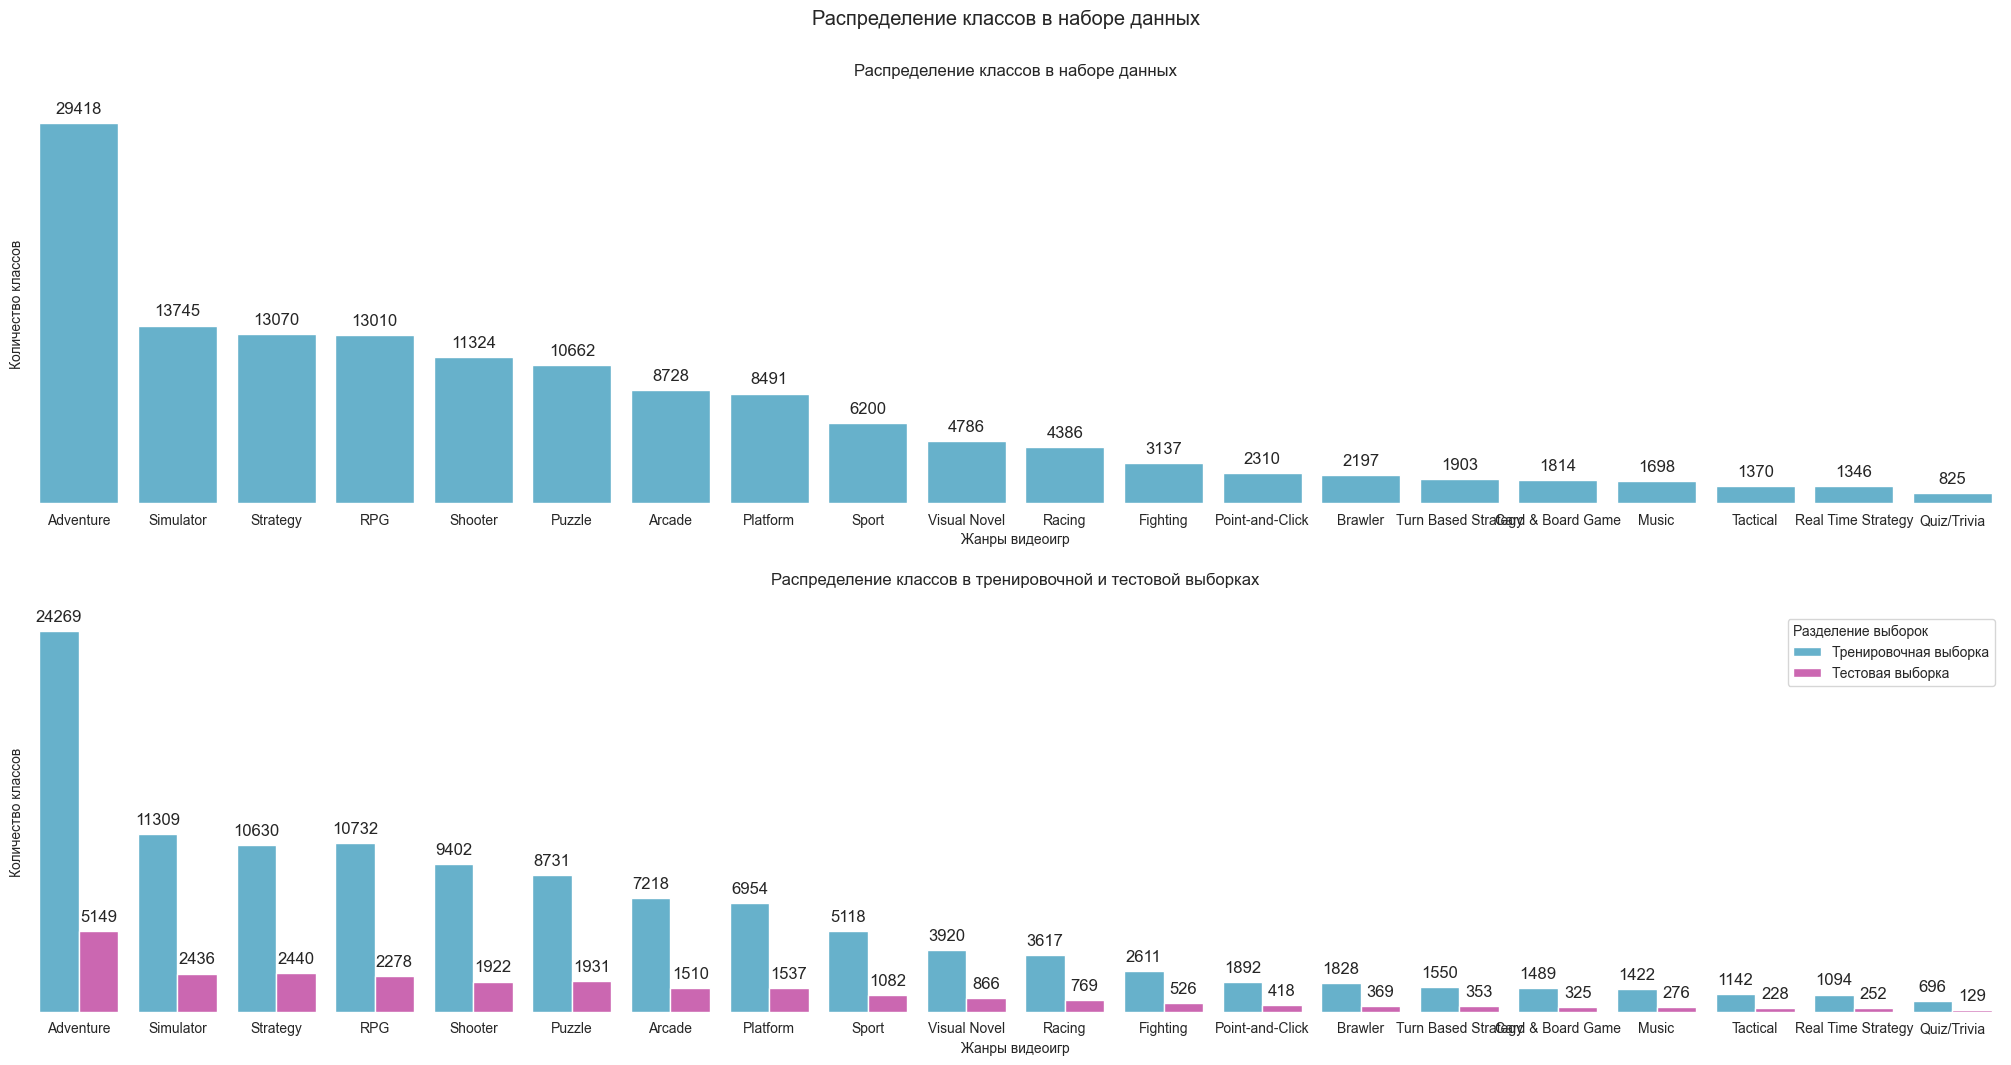

In [54]:
balance.balance(y_train, y_valid, labels)

В наборе данных **присутствует дисбаланс классов**. **Мажоритарным** классом является класс **Adventure** (количество экземпляров более **29 тыс.**). **Миноритарным** классом является класс **Quiz/Trivia** (количество экземпляров менее **1 тыс.**). **Остальные** классы имеют от **800** до **13 тыс.** экземпляров.

## Частотный анализ

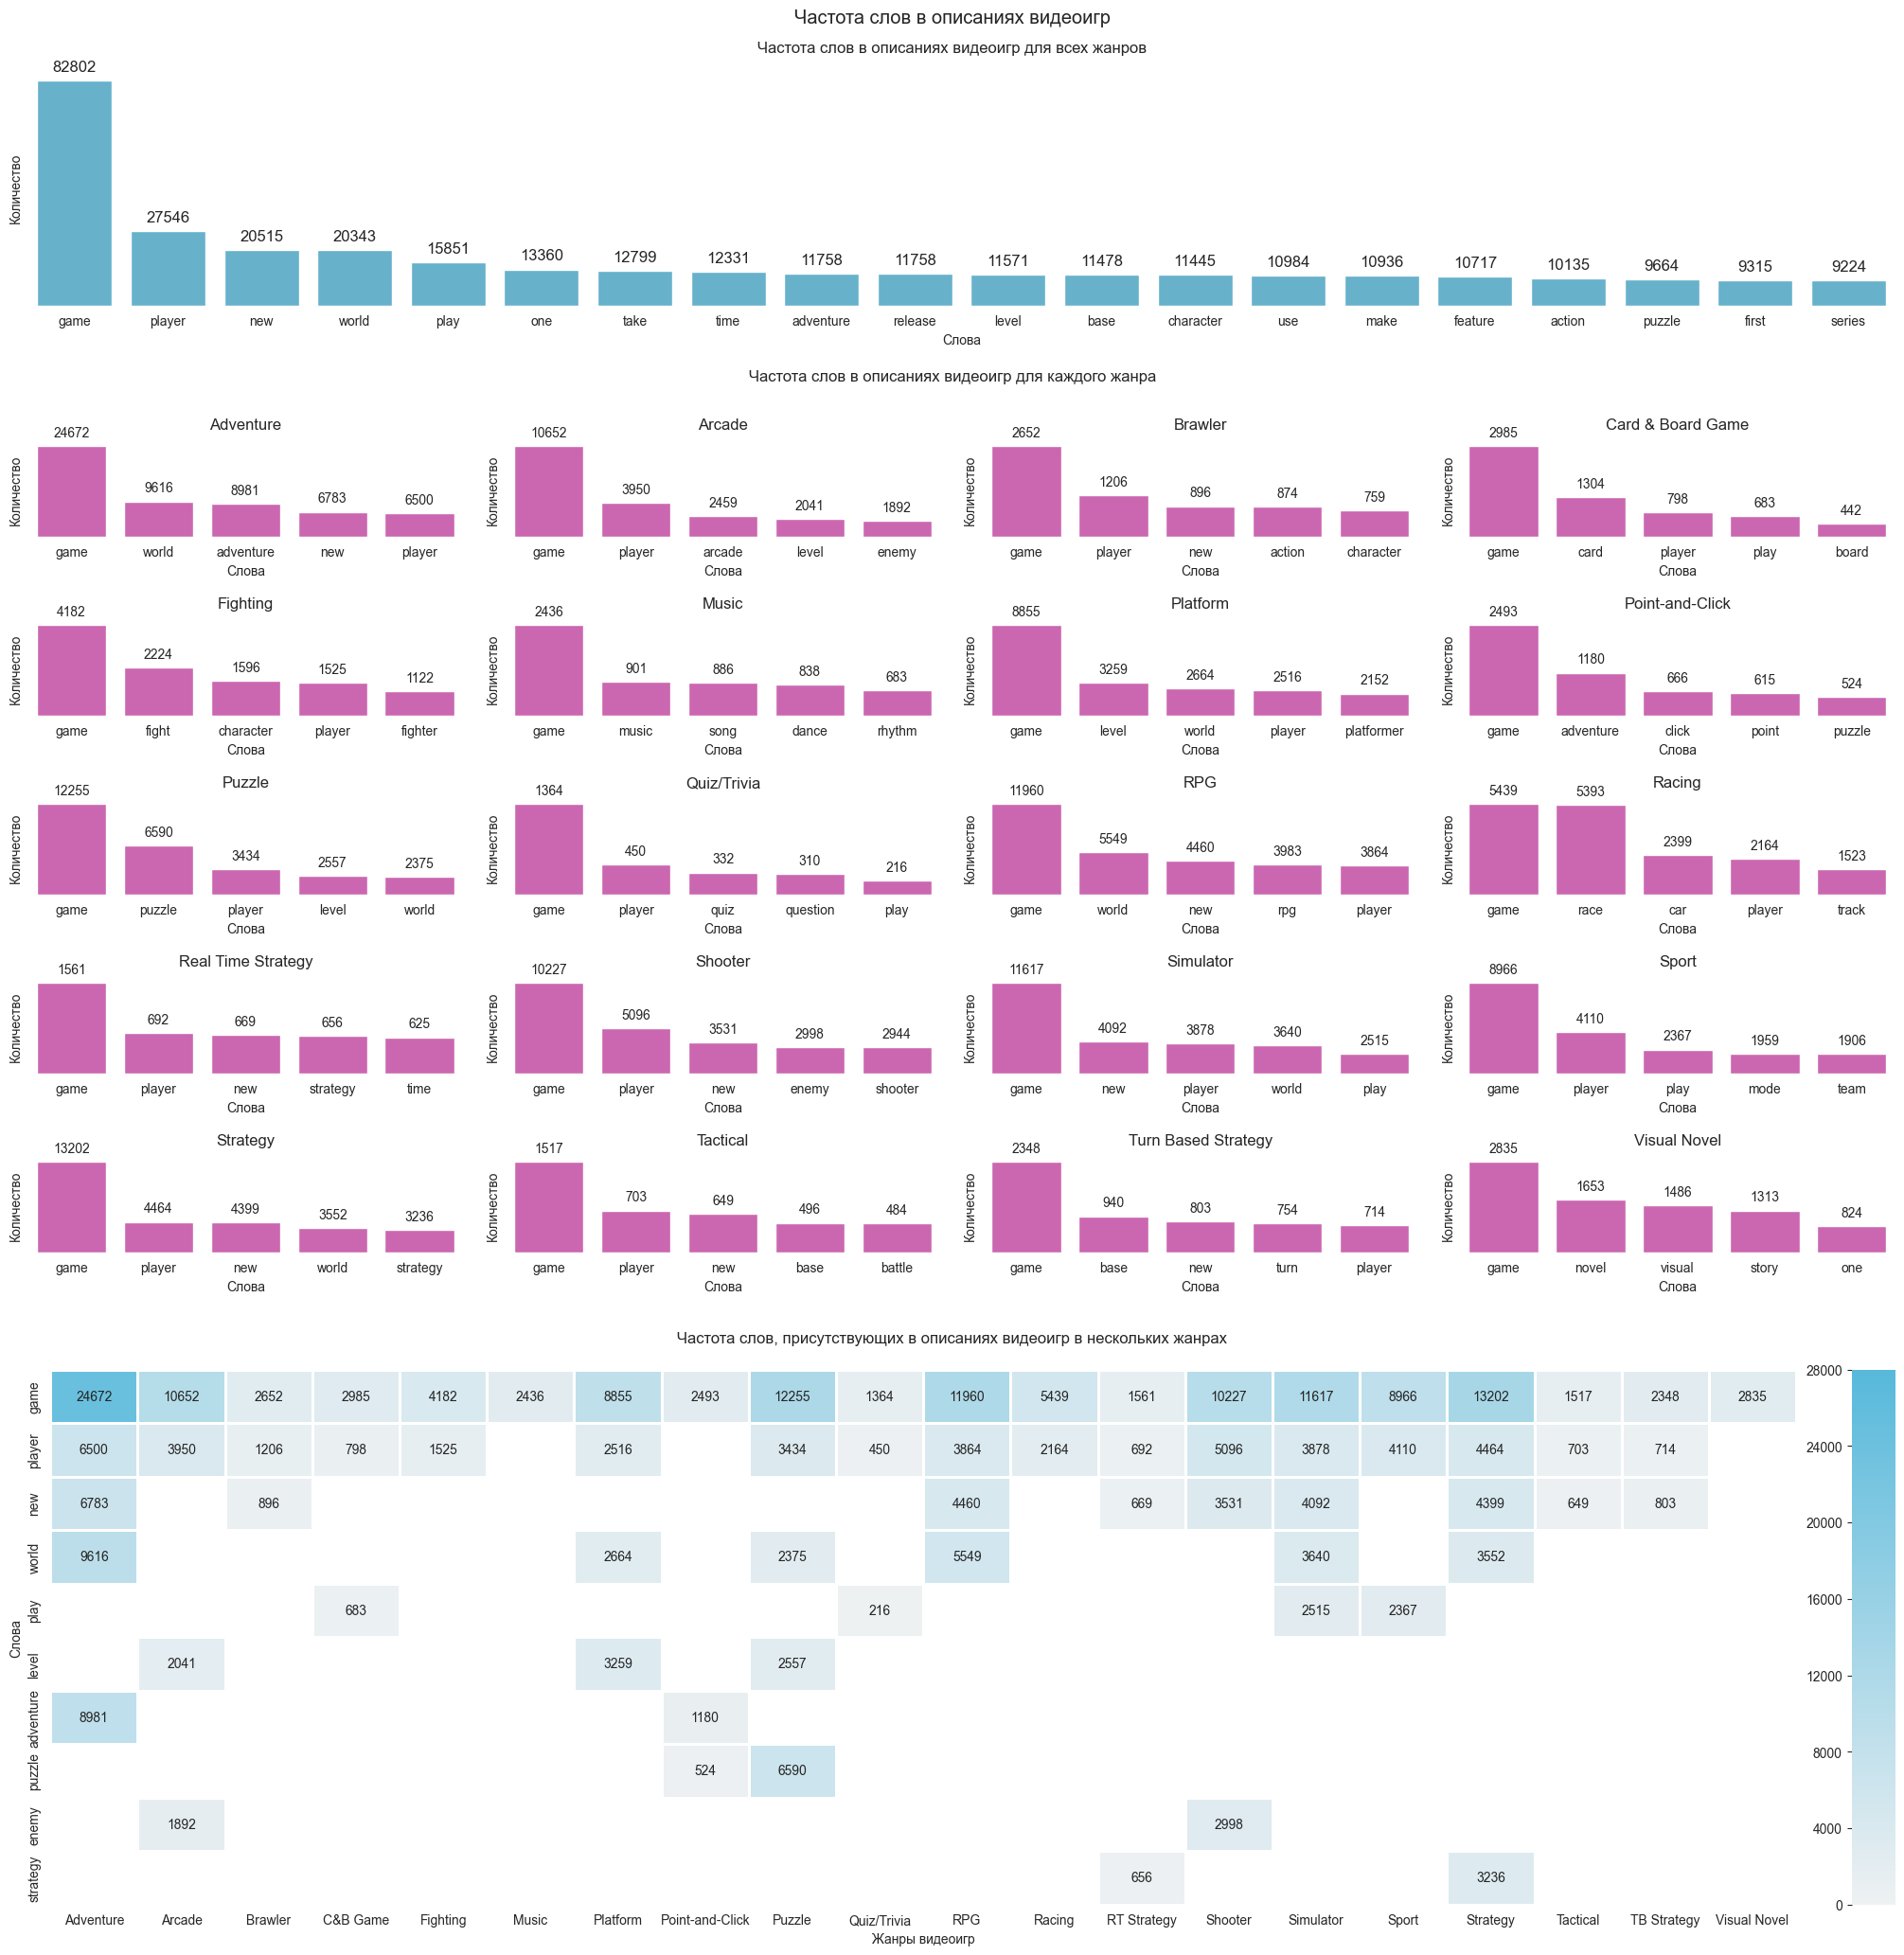

In [55]:
words.words(
    data=pd.concat([x, y], axis=1),
    labels=labels,
    stop_words=stopwords
)

Наиболее часто в описаниях видеоигр встречается слово **game** (приблизительно **70 тыс.** раз). **Остальные слова** встречаются в описаниях видеоигр менее **20 тыс.** раз. Для каждого класса существует свой **уникальный** список наиболее часто встречающихся слов в описаниях видеоигр.

## Тестирование моделей
***

Для стандартизации признаков используем **TfidfVectorizer**.

In [57]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words=stopwords
)

standardizer = Pipeline(
    steps=[
        ('vectorizer', vectorizer)
    ]
)
standardizer

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]))])

Для оценки эффективности **предсказательной способности** модели, будем использовать метрику **f1-weighted**.

In [58]:
f1_weighted = make_scorer(
    score_func=f1_score,
    average='weighted',
    zero_division=0.0
)

В для оценки эффективности были выбраны следующие показатели:
- время обучения;
- время предсказания;
- f1-weighted.

In [59]:
results = pd.DataFrame(
    columns=['Время обучения', 'Время предсказания', 'f1-weighted'],
    index=['ComplementNB', 'SGDClassifier']
)
results.style.format(na_rep='-')

,Время обучения,Время предсказания,f1-weighted
ComplementNB,-,-,-
SGDClassifier,-,-,-


### Тестирование ComplementNB
***

In [60]:
estimator = ComplementNB()
estimator = MultiOutputClassifier(
    estimator=estimator,
    n_jobs=4
)

pipeline = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator)
    ]
)
pipeline

Pipeline(steps=[('standardizer',
                 Pipeline(steps=[('vectorizer',
                                  TfidfVectorizer(stop_words=['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', "you're",
                                                              "you've",
                                                              "you'll", "you'd",
                                                              'your', 'yours',
                                                              'yourself',
                                                              'yourselves',
                                                              'he', 'him',
                                                              'his', 'himself',
                                                              'she', "she's",
                                                              'her', 'hers',
                                                              'herself', 'it',
                                                              "it's", 'its',
                                                              'itself', ...]))])),
                ('estimator',
                 MultiOutputClassifier(estimator=ComplementNB(), n_jobs=4))])

In [61]:
param_grid = {
    'standardizer__vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'standardizer__vectorizer__norm': [None, 'l1', 'l2'],
    'standardizer__vectorizer__sublinear_tf': [True, False],
    'standardizer__vectorizer__max_features': np.arange(
        start=500_000,
        stop=1_000_001,
        step=250_000
    ).tolist(),
    'estimator__estimator__norm': [False, True],
    'estimator__estimator__alpha': np.linspace(
        start=1.0,
        stop=10.0,
        num=10
    ).round(5).tolist()
}

In [62]:
best_param = {
    "estimator__estimator__alpha": [2.0],
    "estimator__estimator__norm": [False],
    "standardizer__vectorizer__max_features": [500000],
    "standardizer__vectorizer__ngram_range": [(1, 3)],
    "standardizer__vectorizer__norm": [None],
    "standardizer__vectorizer__sublinear_tf": [False]
}

In [63]:
%%time
complement_nb = GridSearchCV(
    estimator=pipeline, 
    param_grid=best_param, 
    scoring=f1_weighted,
    error_score=0.0,
    cv=3, 
    verbose=3,
    refit=True
)
complement_nb.fit(x_train, y_train); 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__estimator__alpha=2.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=500000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=False;, score=0.586 total time=  24.8s
[CV 2/3] END estimator__estimator__alpha=2.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=500000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=False;, score=0.588 total time=  21.0s
[CV 3/3] END estimator__estimator__alpha=2.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=500000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=False;, score=0.586 total time=  23.1s
CPU times: total: 1min 17s
Wall time: 1min 32s


In [64]:
cv_results = pd.DataFrame(
    data=complement_nb.cv_results_, 
).sort_values('rank_test_score')
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__estimator__alpha,param_estimator__estimator__norm,param_standardizer__vectorizer__max_features,param_standardizer__vectorizer__ngram_range,param_standardizer__vectorizer__norm,param_standardizer__vectorizer__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,17.413276,1.576604,5.689383,0.452725,2.0,False,500000,"(1, 3)",None,False,"{'estimator__estimator__alpha': 2.0, 'estimato...",0.585653,0.588381,0.585665,0.586566,0.001283,1


In [65]:
results.loc['ComplementNB', 'Время обучения'] = cv_results.loc[0, 'mean_fit_time']
results.loc['ComplementNB', 'Время предсказания'] = cv_results.loc[0, 'mean_score_time']
results.loc['ComplementNB', 'f1-weighted'] = cv_results.loc[0, 'mean_test_score']

In [66]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=complement_nb.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_SPLITTING_STRATEGY_TRAIN_SIZES,
    cv=ShuffleSplit(
        n_splits=LEARNING_CURVE_SPLITTING_STRATEGY_N_SPLITS,
        test_size=LEARNING_CURVE_SPLITTING_STRATEGY_TEST_SIZE,
        random_state=RANDOM_STATE
    ),
    n_jobs=N_JOBS,
    scoring=f1_weighted,
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  544  2723 10895 21790 32685 43580 54476]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:  1.1min remaining:  2.1min
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:  2.1min remaining:   59.1s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  3.3min finished


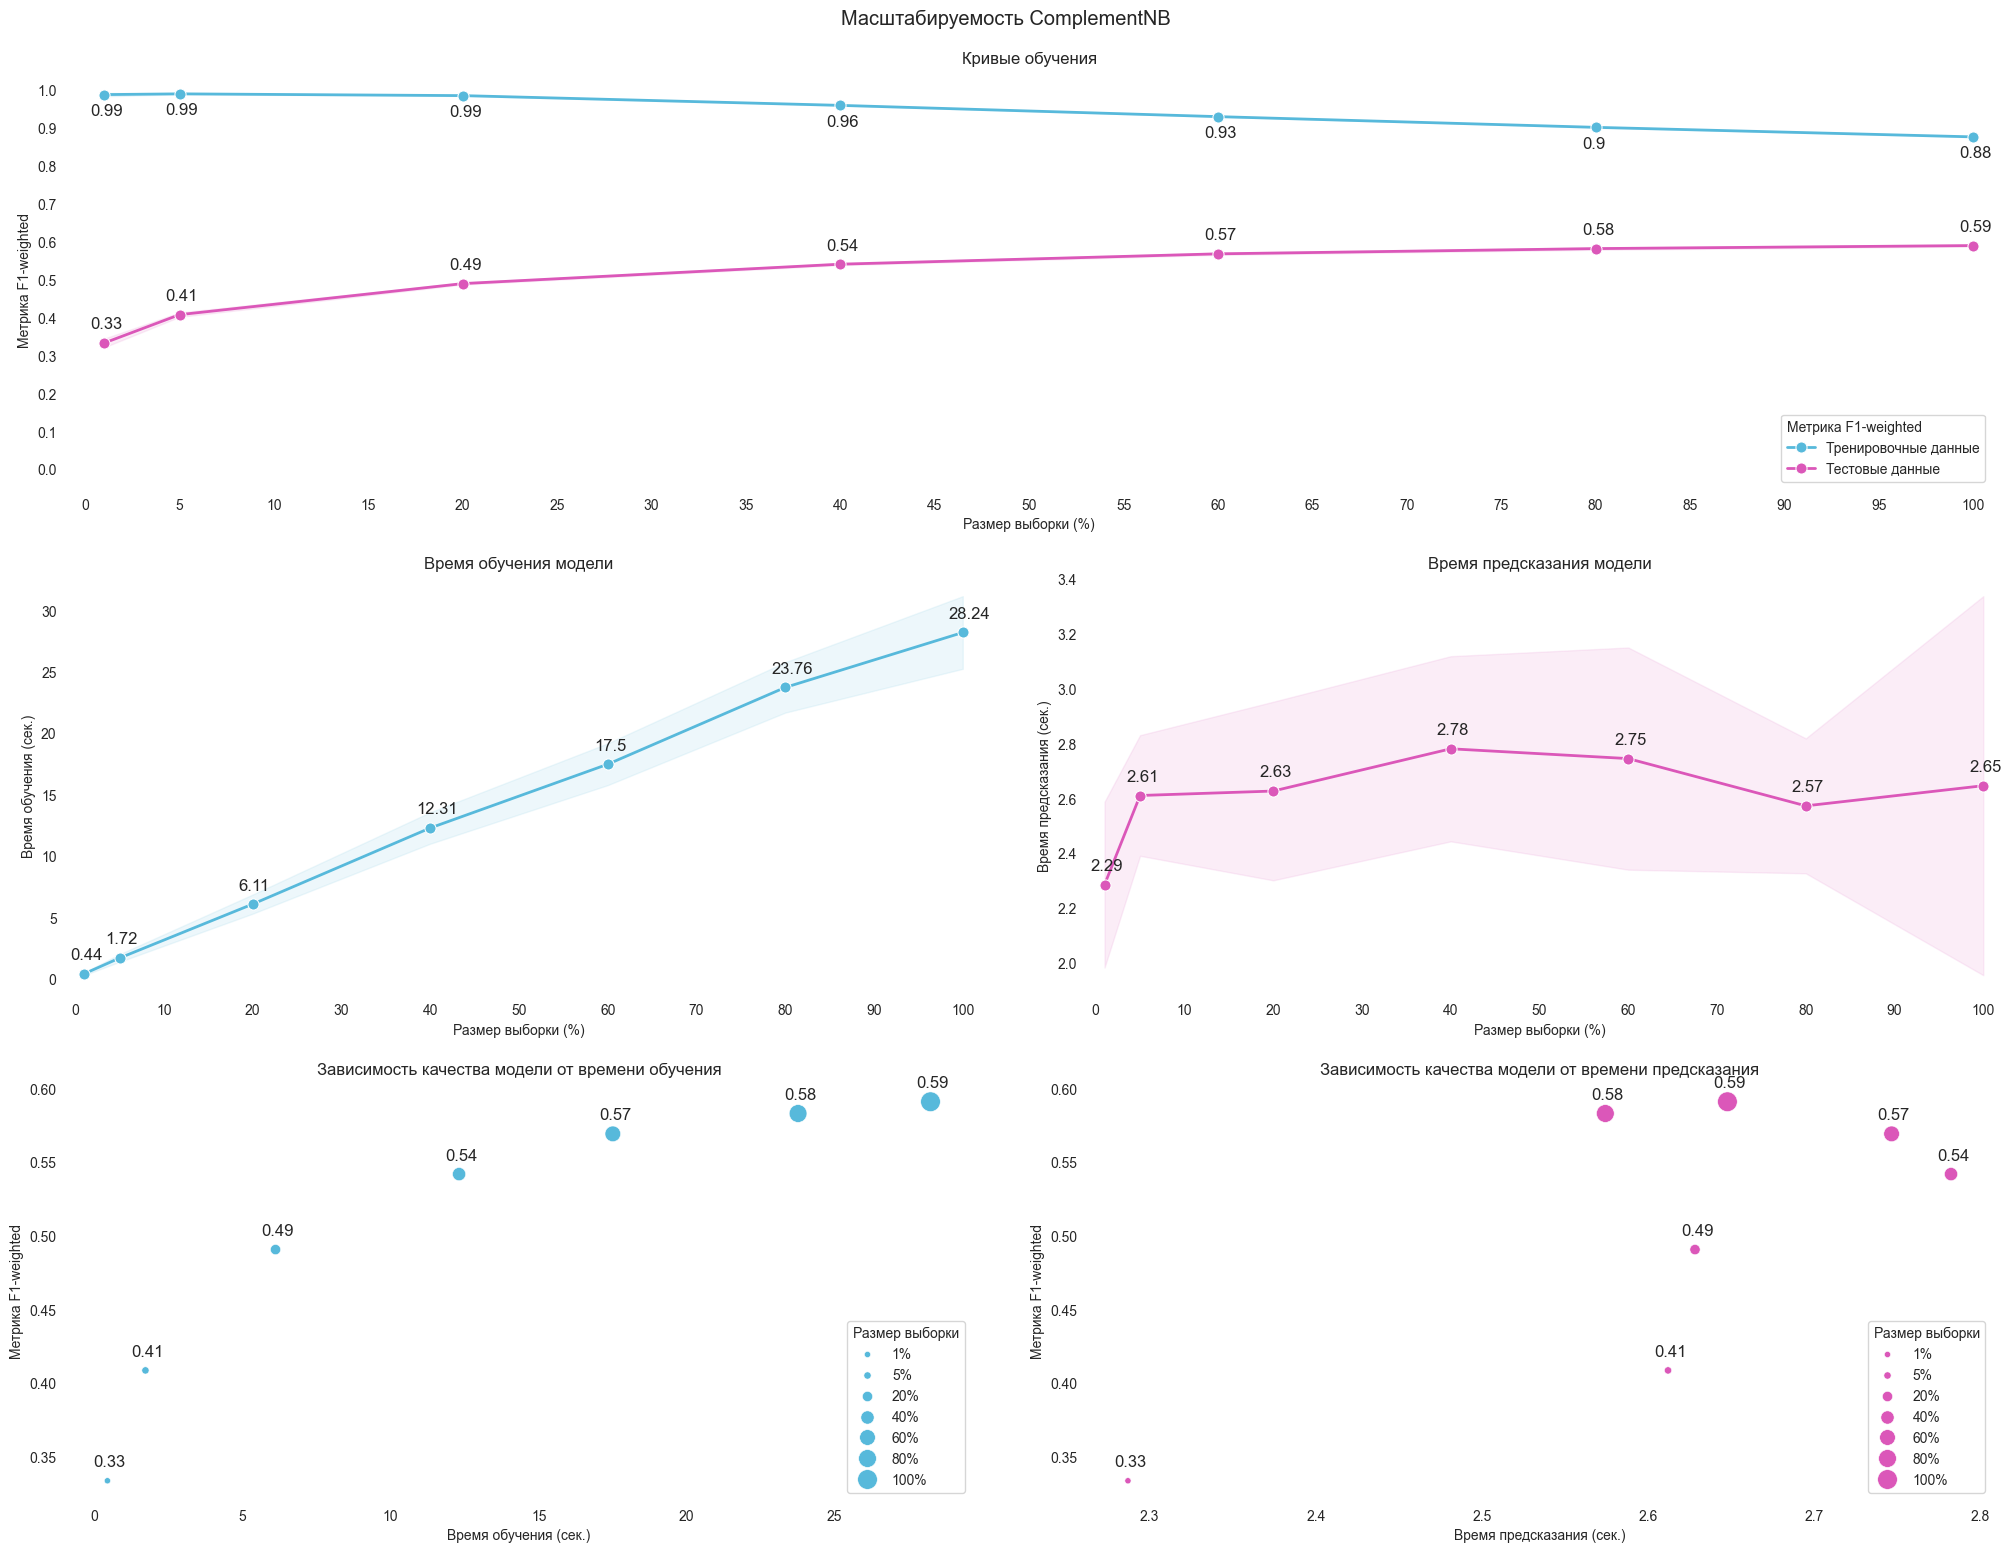

In [67]:
x_train_size = x_train.shape[0]
x_train_size *= (1 - LEARNING_CURVE_SPLITTING_STRATEGY_TEST_SIZE)
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость ComplementNB',
)

Кривые обучения показывают, что **присутствует** признак переобучения модели. **Добавление новых данных** возможно **улучшит** предсказательную способность модели. При добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.

In [68]:
predict = complement_nb.predict(x_valid)
predict_proba = complement_nb.predict_proba(x_valid)

In [69]:
f1 = f1_score(
    y_true=y_valid,
    y_pred=predict,
    average='weighted'
)

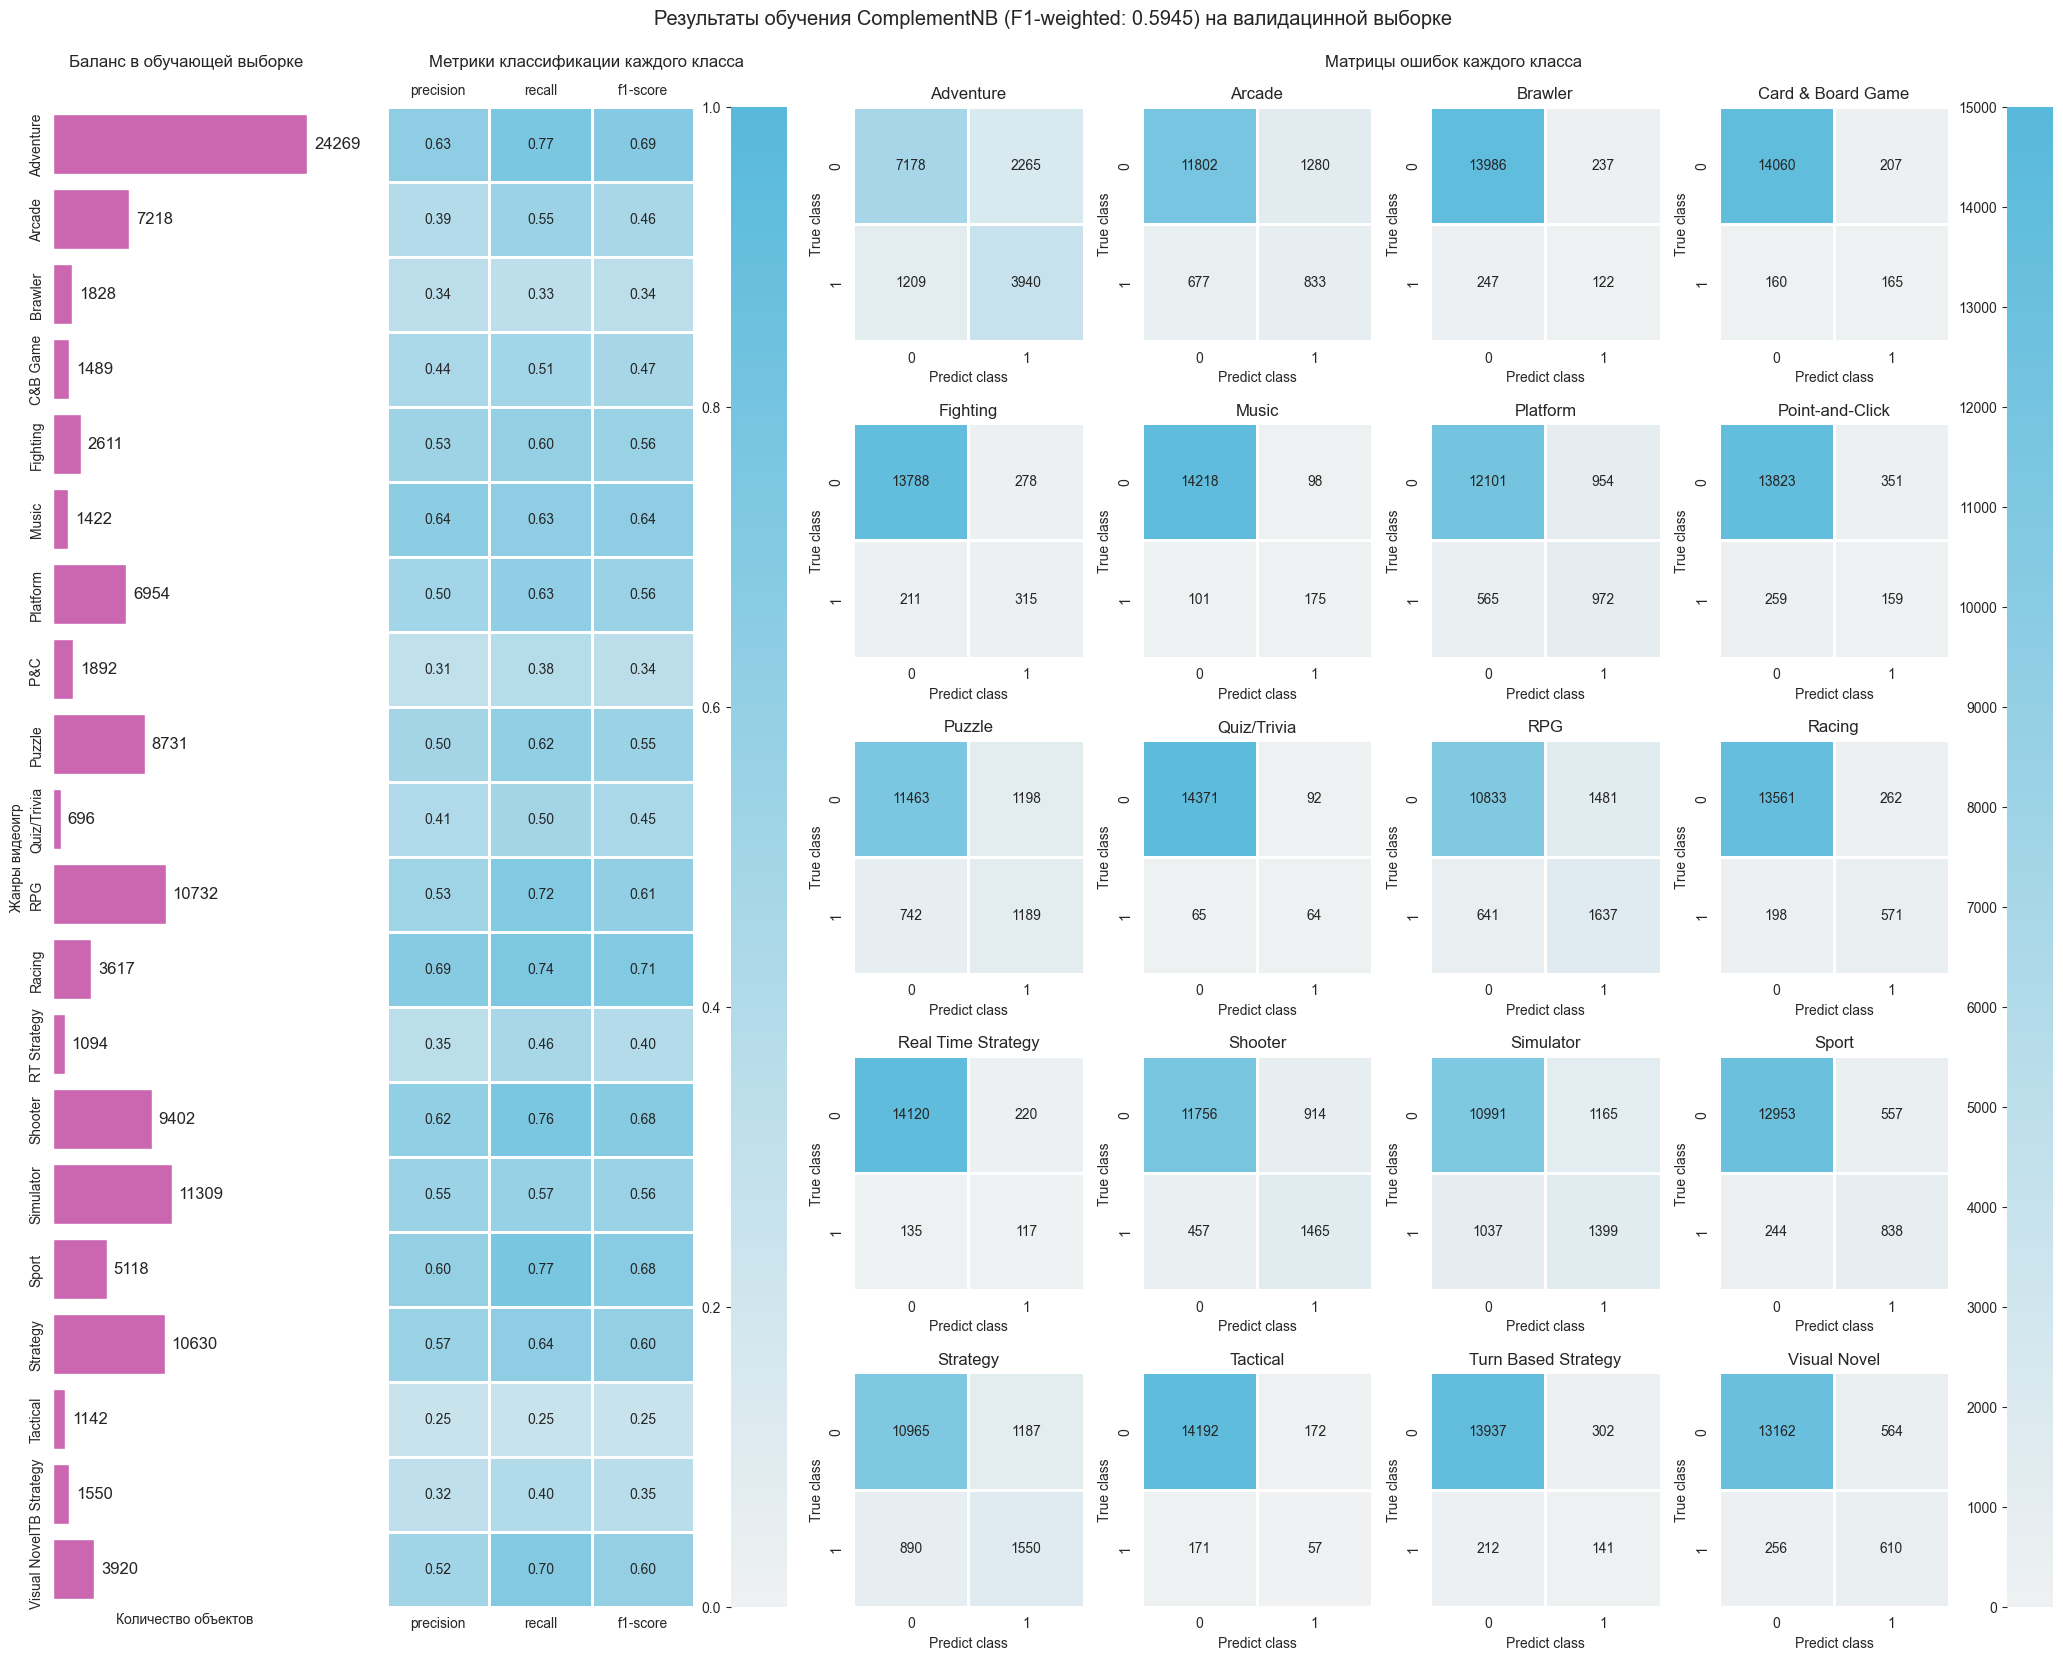

In [70]:
metrics.metrics(
    y_test=y_valid,
    y_predict=pd.DataFrame(predict),
    y_train=y_train,
    title=f'Результаты обучения ComplementNB '
          f'(F1-weighted: {f1:.4f}) на валидацинной выборке',
    labels=labels
)

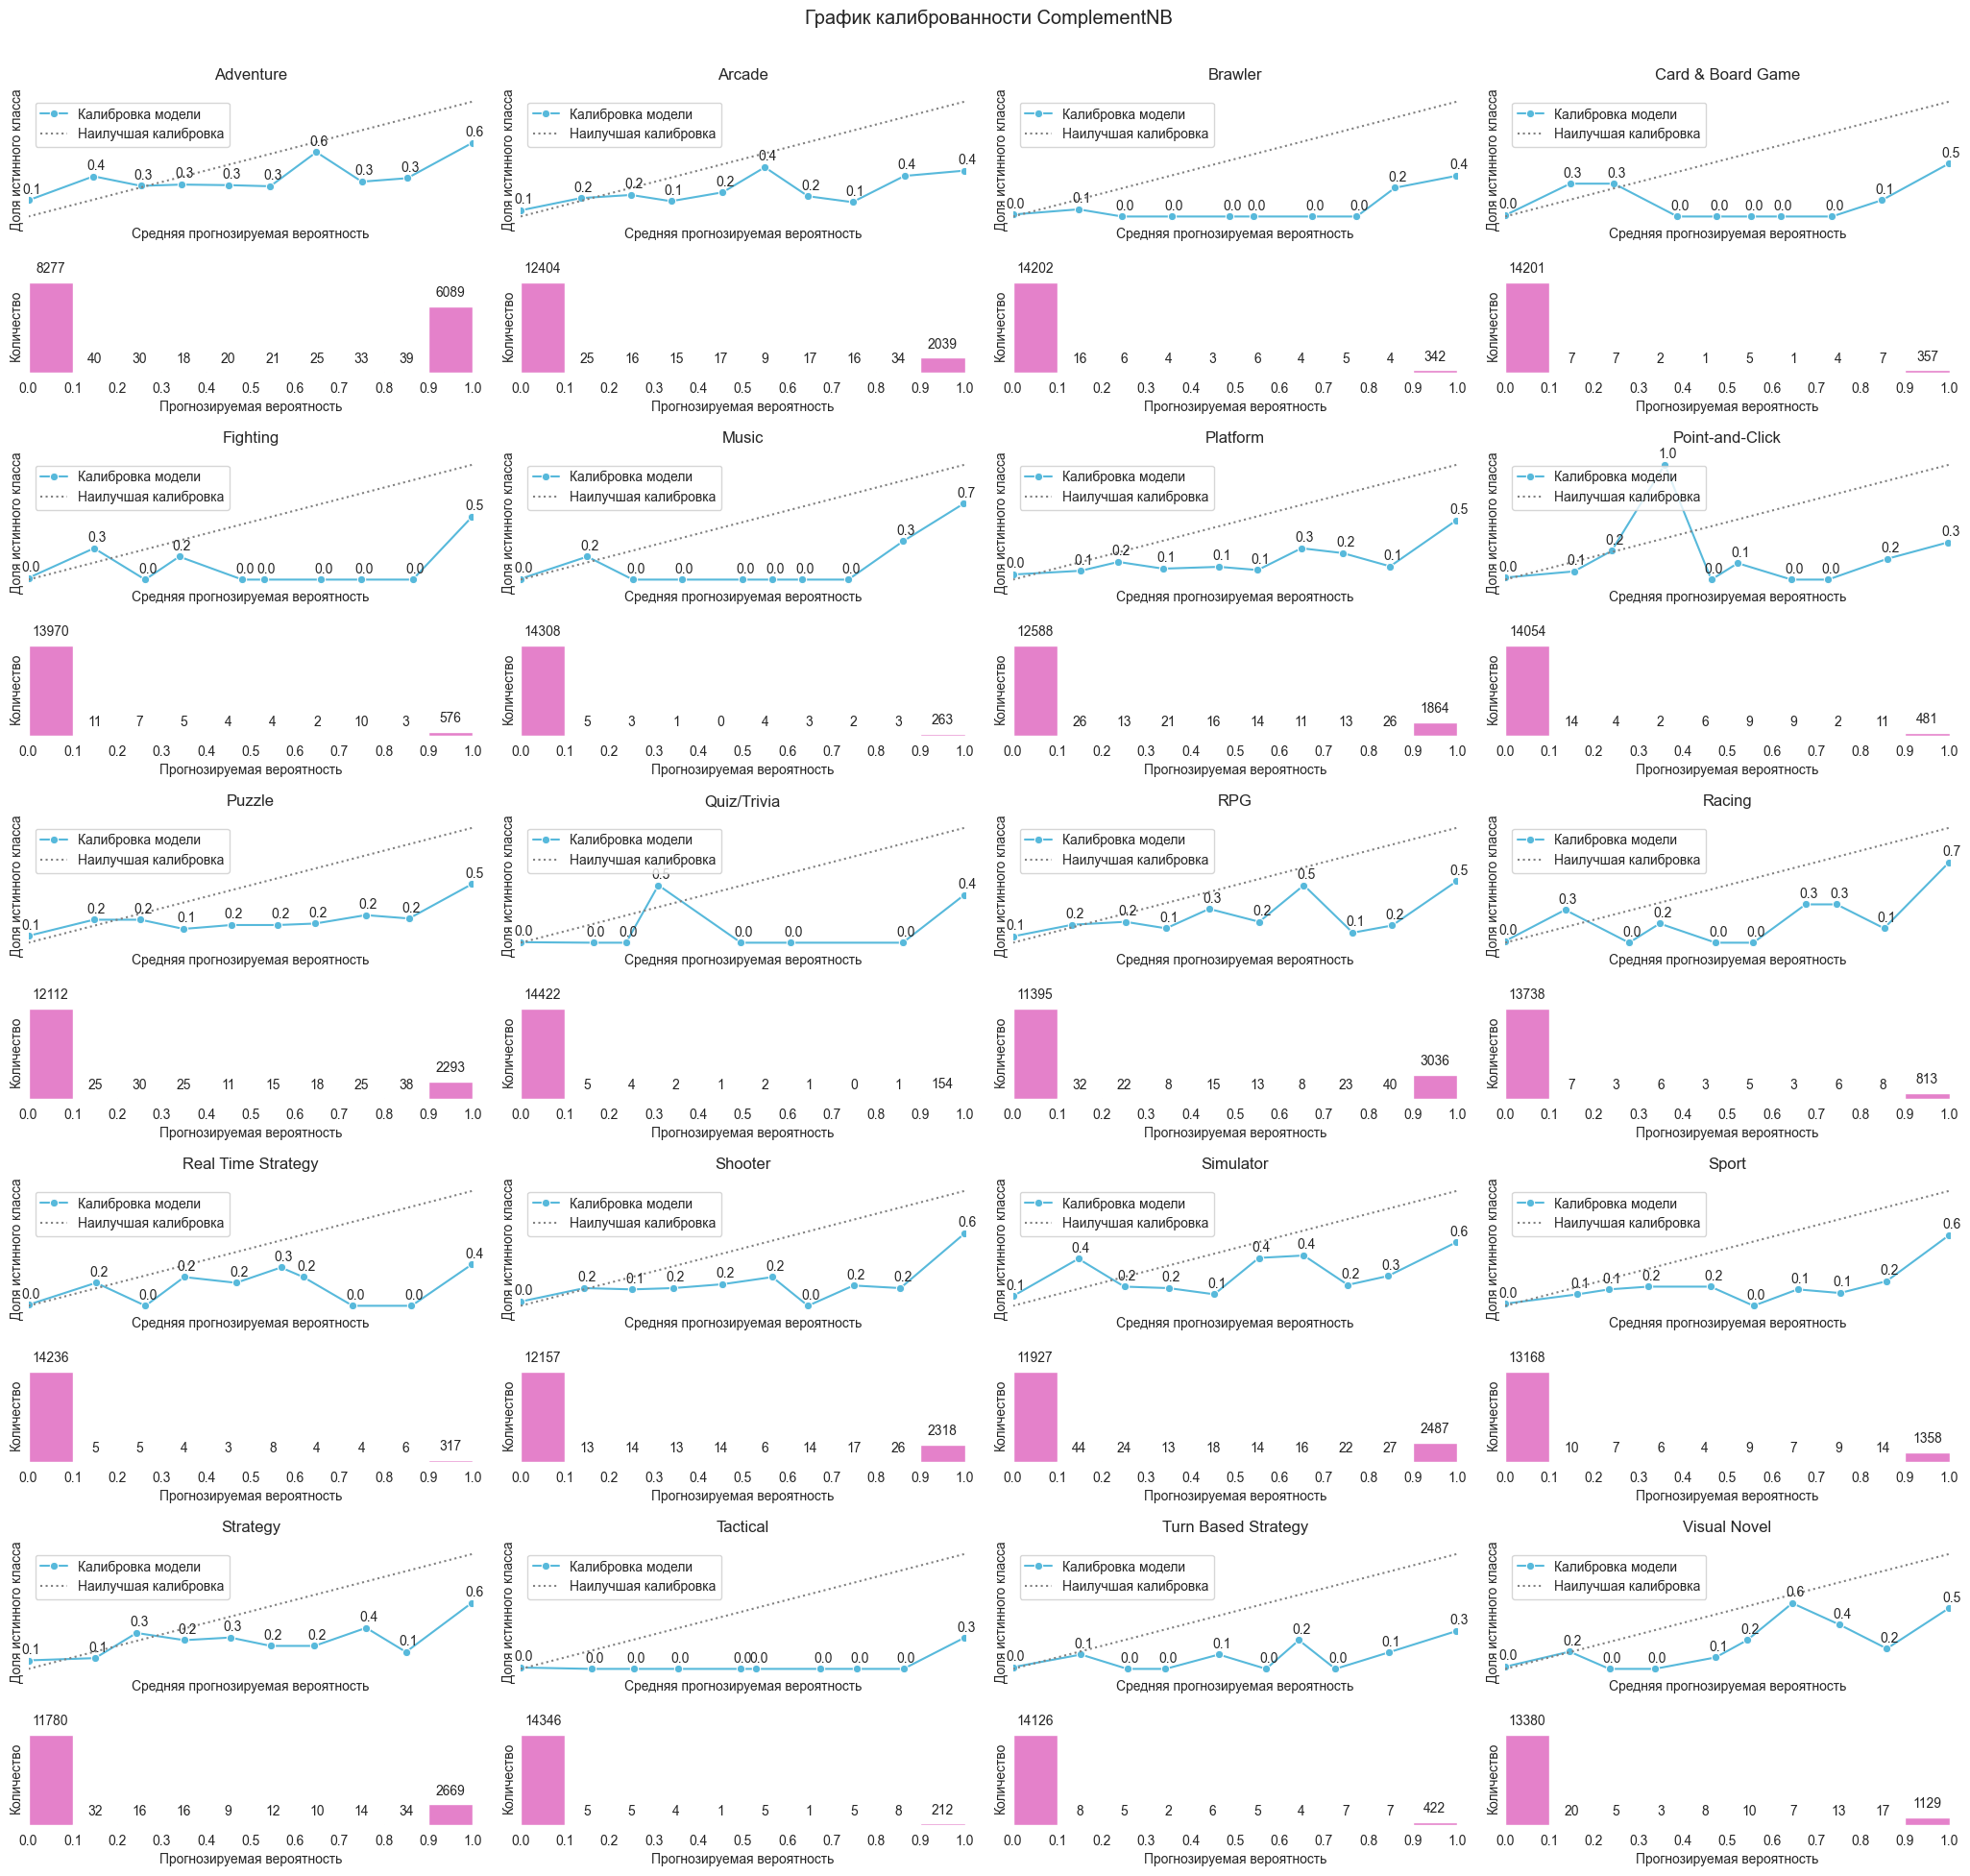

In [71]:
calibration.calibration(
    y_true=y_valid,
    y_proba=[pd.DataFrame(x) for x in predict_proba], 
    labels=labels, 
    title='График калиброванности ComplementNB'
)

Модель имеет **низкую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу. Прогнозируемая вероятность распределена **неравномерно**, приобладают значения в диапазонах от **0.0** до **0.1** и от **0.9** до **1.0**. Вероятнее всего, это связанос тем, что модель наивного байеса считает признаки независимыми. **Необходима** калибровка модели. 

### Тестирование SGDClassifier
***

In [72]:
estimator = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    random_state=42
)

estimator = MultiOutputClassifier(
    estimator=estimator,
    n_jobs=4
)

pipeline = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator)
    ]
)
pipeline

Pipeline(steps=[('standardizer',
                 Pipeline(steps=[('vectorizer',
                                  TfidfVectorizer(stop_words=['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', "you're",
                                                              "you've",
                                                              "you'll", "you'd",
                                                              'your', 'yours',
                                                              'yourself',
                                                              'yourselves',
                                                              'he', 'him',
                                                              'his', 'himself',
                                                              'she', "she's",
                                                              'her', 'hers',
                                                              'herself', 'it',
                                                              "it's", 'its',
                                                              'itself', ...]))])),
                ('estimator',
                 MultiOutputClassifier(estimator=SGDClassifier(loss='log_loss',
                                                               penalty='elasticnet',
                                                               random_state=42),
                                       n_jobs=4))])

In [73]:
param_grid = {
    'standardizer__vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'standardizer__vectorizer__norm': [None, 'l1', 'l2'],
    'standardizer__vectorizer__sublinear_tf': [True],
    'standardizer__vectorizer__max_features': np.arange(
        start=750_000,
        stop=1_000_001,
        step=250_000
    ).tolist(),
    'estimator__estimator__alpha': np.linspace(
        start=0.1,
        stop=0.5,
        num=5
    ).round(5).tolist(),
    'estimator__estimator__class_weight': [None, 'balanced'],
    'estimator__estimator__l1_ratio': np.linspace(
        start=0.0,
        stop=0.5,
        num=6
    ).round(5).tolist()
}

In [74]:
best_param = {
    "estimator__estimator__alpha": [0.1],
    "estimator__estimator__class_weight": ["balanced"],
    "estimator__estimator__l1_ratio": [0.0],
    "standardizer__vectorizer__max_features": [1000000],
    "standardizer__vectorizer__ngram_range": [(1, 3)],
    'standardizer__vectorizer__sublinear_tf': [True],
    "standardizer__vectorizer__norm": [None]
}

In [75]:
%%time
sgd = GridSearchCV(
    estimator=pipeline, 
    param_grid=best_param, 
    scoring=f1_weighted,
    error_score=0.0,
    cv=3, 
    verbose=3,
    refit=True
)
sgd.fit(x_train, y_train); 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END estimator__estimator__alpha=0.1, estimator__estimator__class_weight=balanced, estimator__estimator__l1_ratio=0.0, standardizer__vectorizer__max_features=1000000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=True;, score=0.595 total time=  24.0s
[CV 2/3] END estimator__estimator__alpha=0.1, estimator__estimator__class_weight=balanced, estimator__estimator__l1_ratio=0.0, standardizer__vectorizer__max_features=1000000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer__vectorizer__sublinear_tf=True;, score=0.598 total time=  23.7s
[CV 3/3] END estimator__estimator__alpha=0.1, estimator__estimator__class_weight=balanced, estimator__estimator__l1_ratio=0.0, standardizer__vectorizer__max_features=1000000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=None, standardizer_

In [76]:
cv_results = pd.DataFrame(
    data=sgd.cv_results_, 
).sort_values('rank_test_score')
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__estimator__alpha,param_estimator__estimator__class_weight,param_estimator__estimator__l1_ratio,param_standardizer__vectorizer__max_features,param_standardizer__vectorizer__ngram_range,param_standardizer__vectorizer__norm,param_standardizer__vectorizer__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,21.296685,0.262102,3.030296,0.330593,0.1,balanced,0.0,1000000,"(1, 3)",None,True,"{'estimator__estimator__alpha': 0.1, 'estimato...",0.59526,0.597957,0.59585,0.596356,0.001158,1


In [77]:
results.loc['SGDClassifier', 'Время обучения'] = cv_results.loc[0, 'mean_fit_time']
results.loc['SGDClassifier', 'Время предсказания'] = cv_results.loc[0, 'mean_score_time']
results.loc['SGDClassifier', 'f1-weighted'] = cv_results.loc[0, 'mean_test_score']

In [78]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=sgd.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_SPLITTING_STRATEGY_TRAIN_SIZES,
    cv=ShuffleSplit(
        n_splits=LEARNING_CURVE_SPLITTING_STRATEGY_N_SPLITS,
        test_size=LEARNING_CURVE_SPLITTING_STRATEGY_TEST_SIZE,
        random_state=RANDOM_STATE
    ),
    n_jobs=N_JOBS,
    scoring=f1_weighted,
    return_times=True,
    verbose=LEARNING_CURVE_VERBOSE
)

[learning_curve] Training set sizes: [  544  2723 10895 21790 32685 43580 54476]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:  1.6min remaining:  3.0min
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:  3.4min remaining:  1.5min
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  5.3min finished


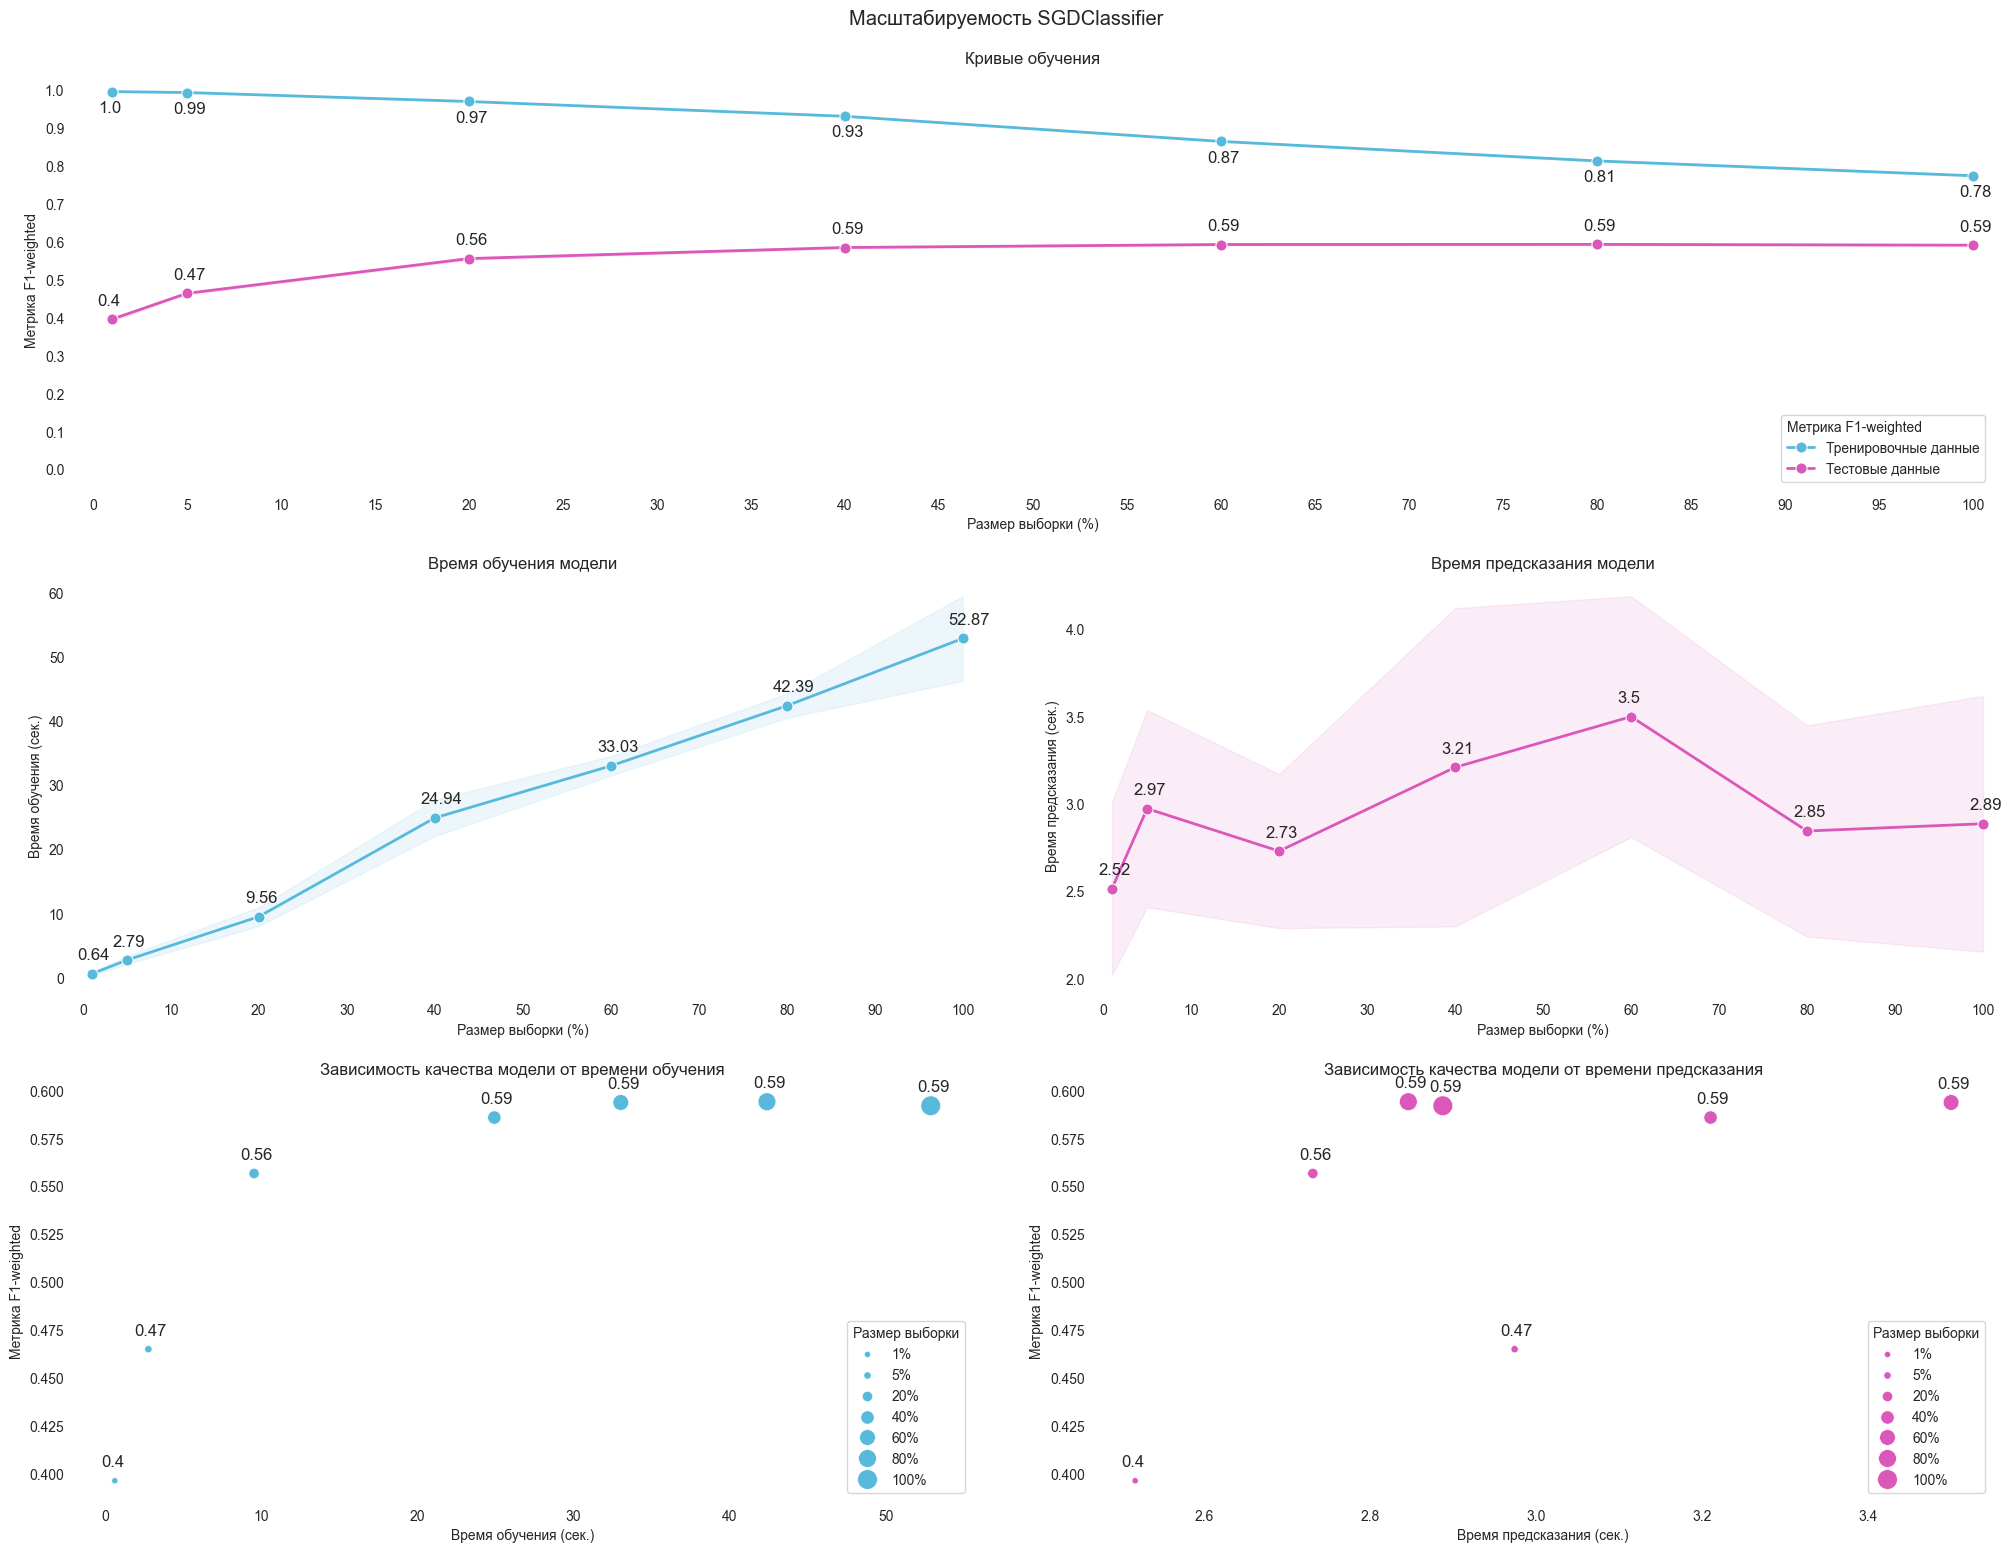

In [79]:
x_train_size = x_train.shape[0]
x_train_size *= (1 - LEARNING_CURVE_SPLITTING_STRATEGY_TEST_SIZE)
scalability.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость SGDClassifier',
)

Кривые обучения показывают, что **присутствует** признак переобучения модели. **Добавление новых данных не улучшит** предсказательную способность модели. При добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.

In [80]:
predict = sgd.predict(x_valid)
predict_proba = sgd.predict_proba(x_valid)

In [81]:
f1 = f1_score(
    y_true=y_valid,
    y_pred=predict,
    average='weighted'
)

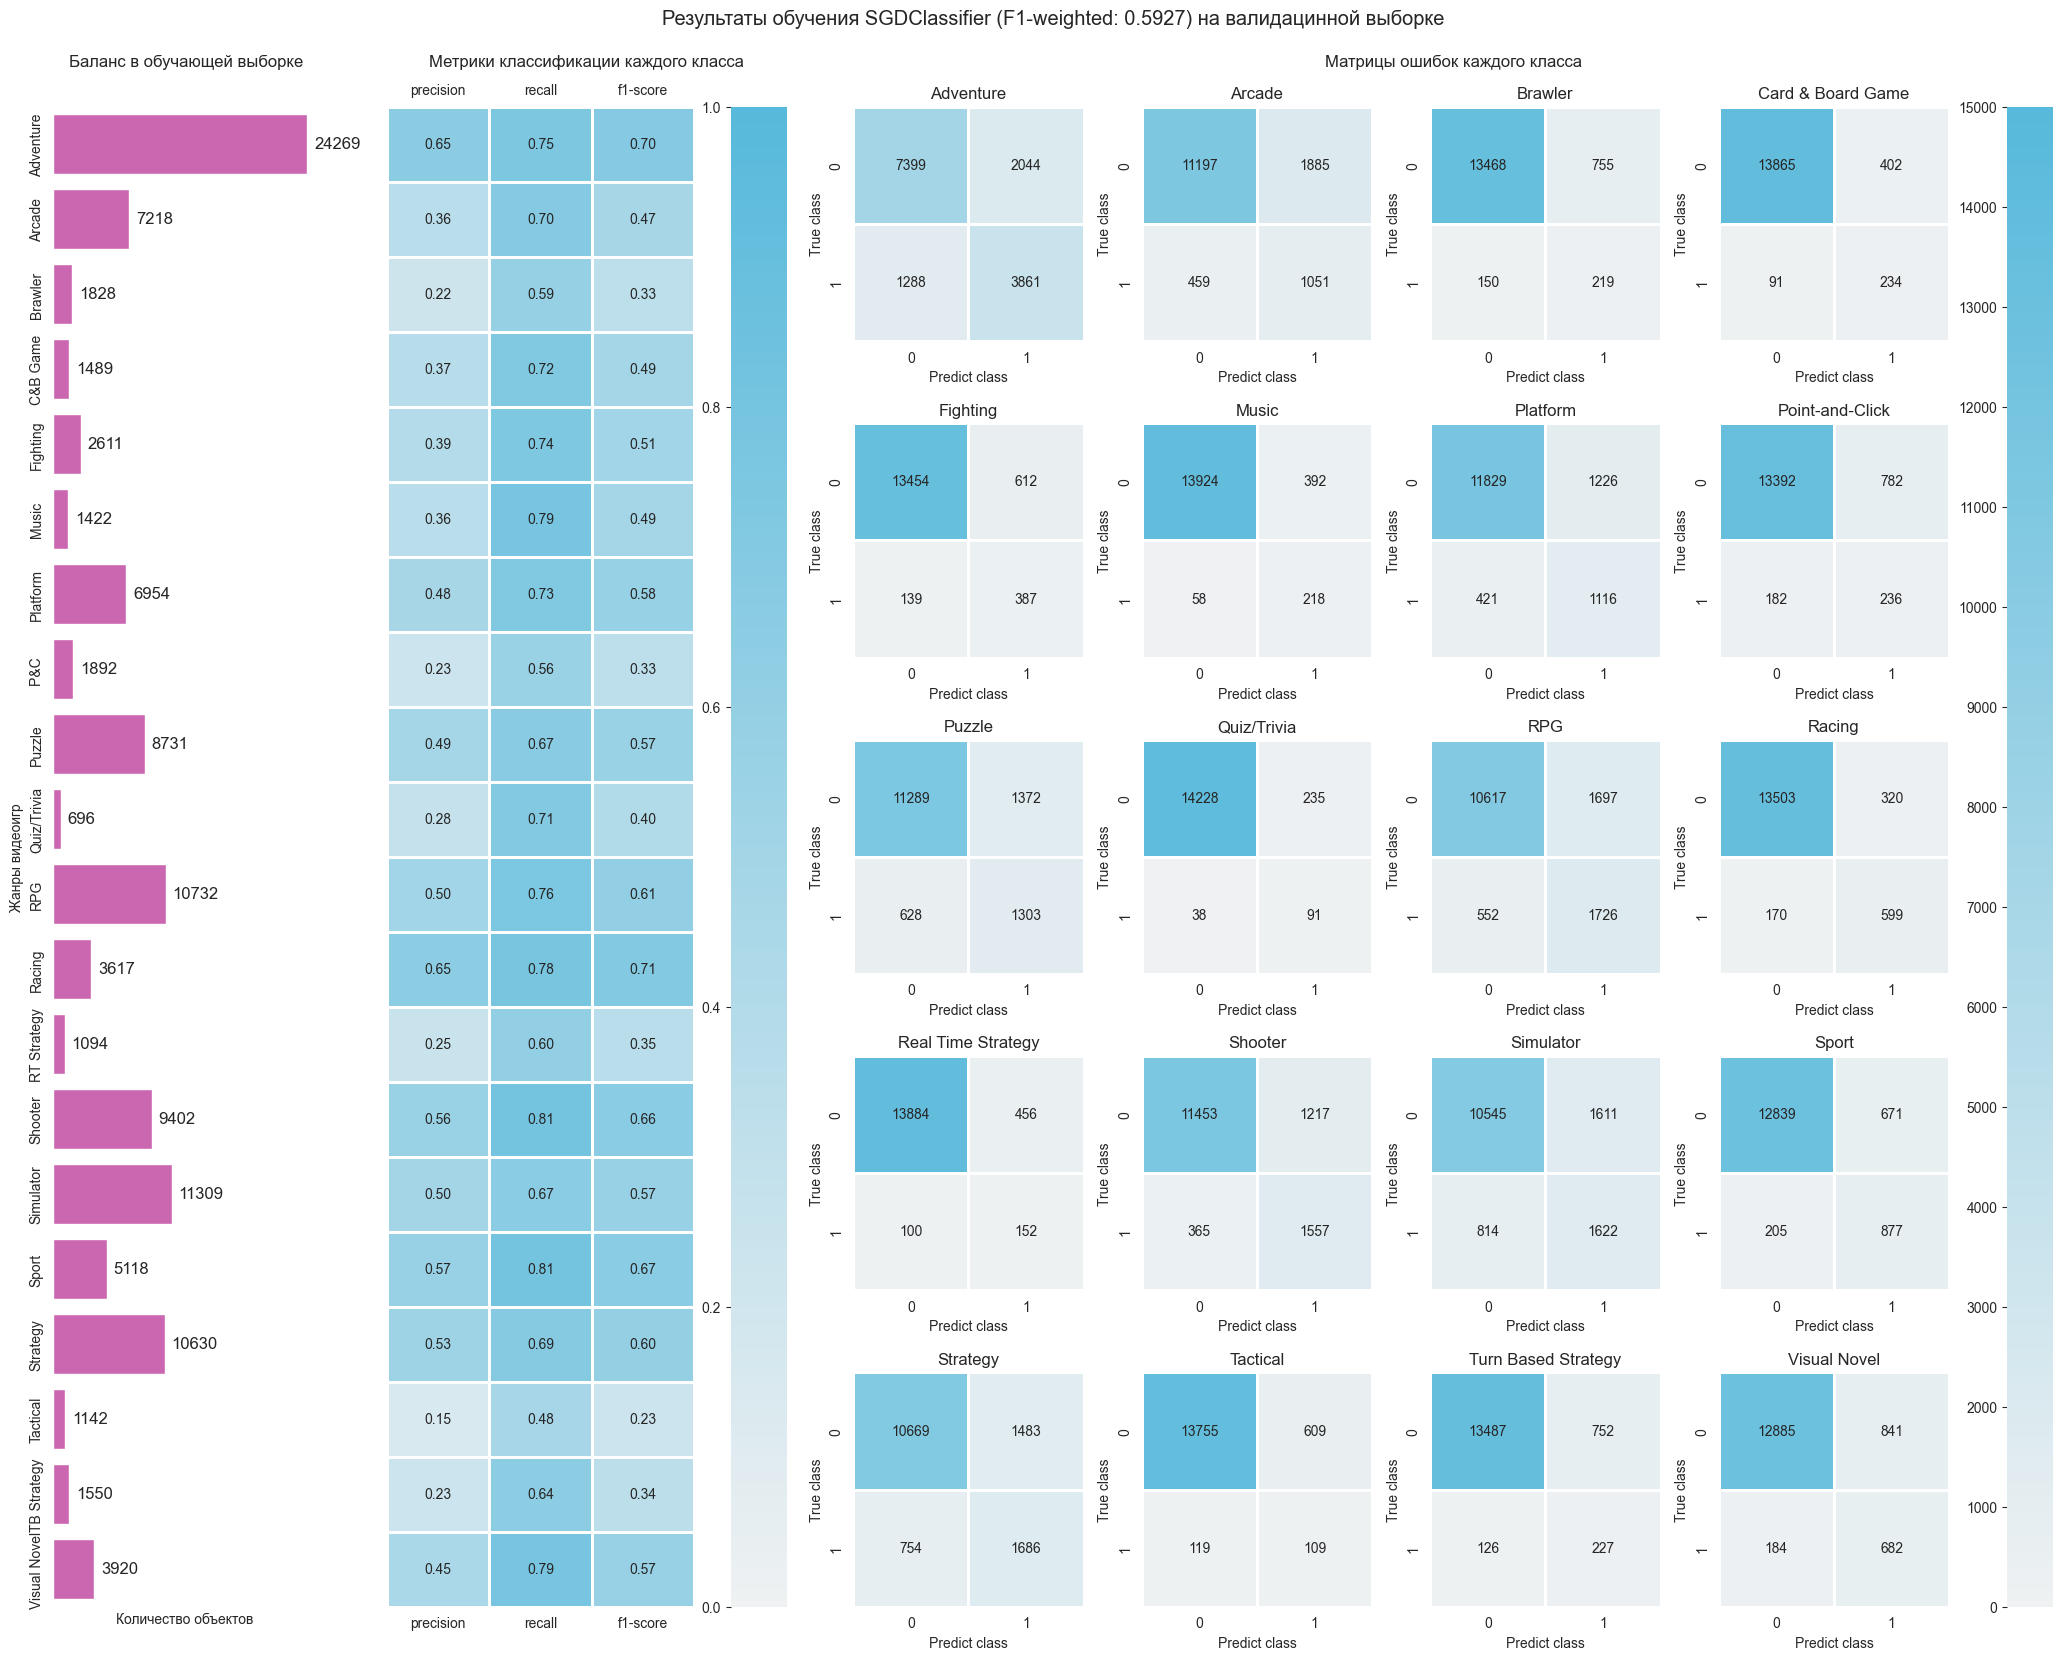

In [82]:
metrics.metrics(
    y_test=y_valid,
    y_predict=pd.DataFrame(predict),
    y_train=y_train,
    title=f'Результаты обучения SGDClassifier '
          f'(F1-weighted: {f1:.4f}) на валидацинной выборке',
    labels=labels
)

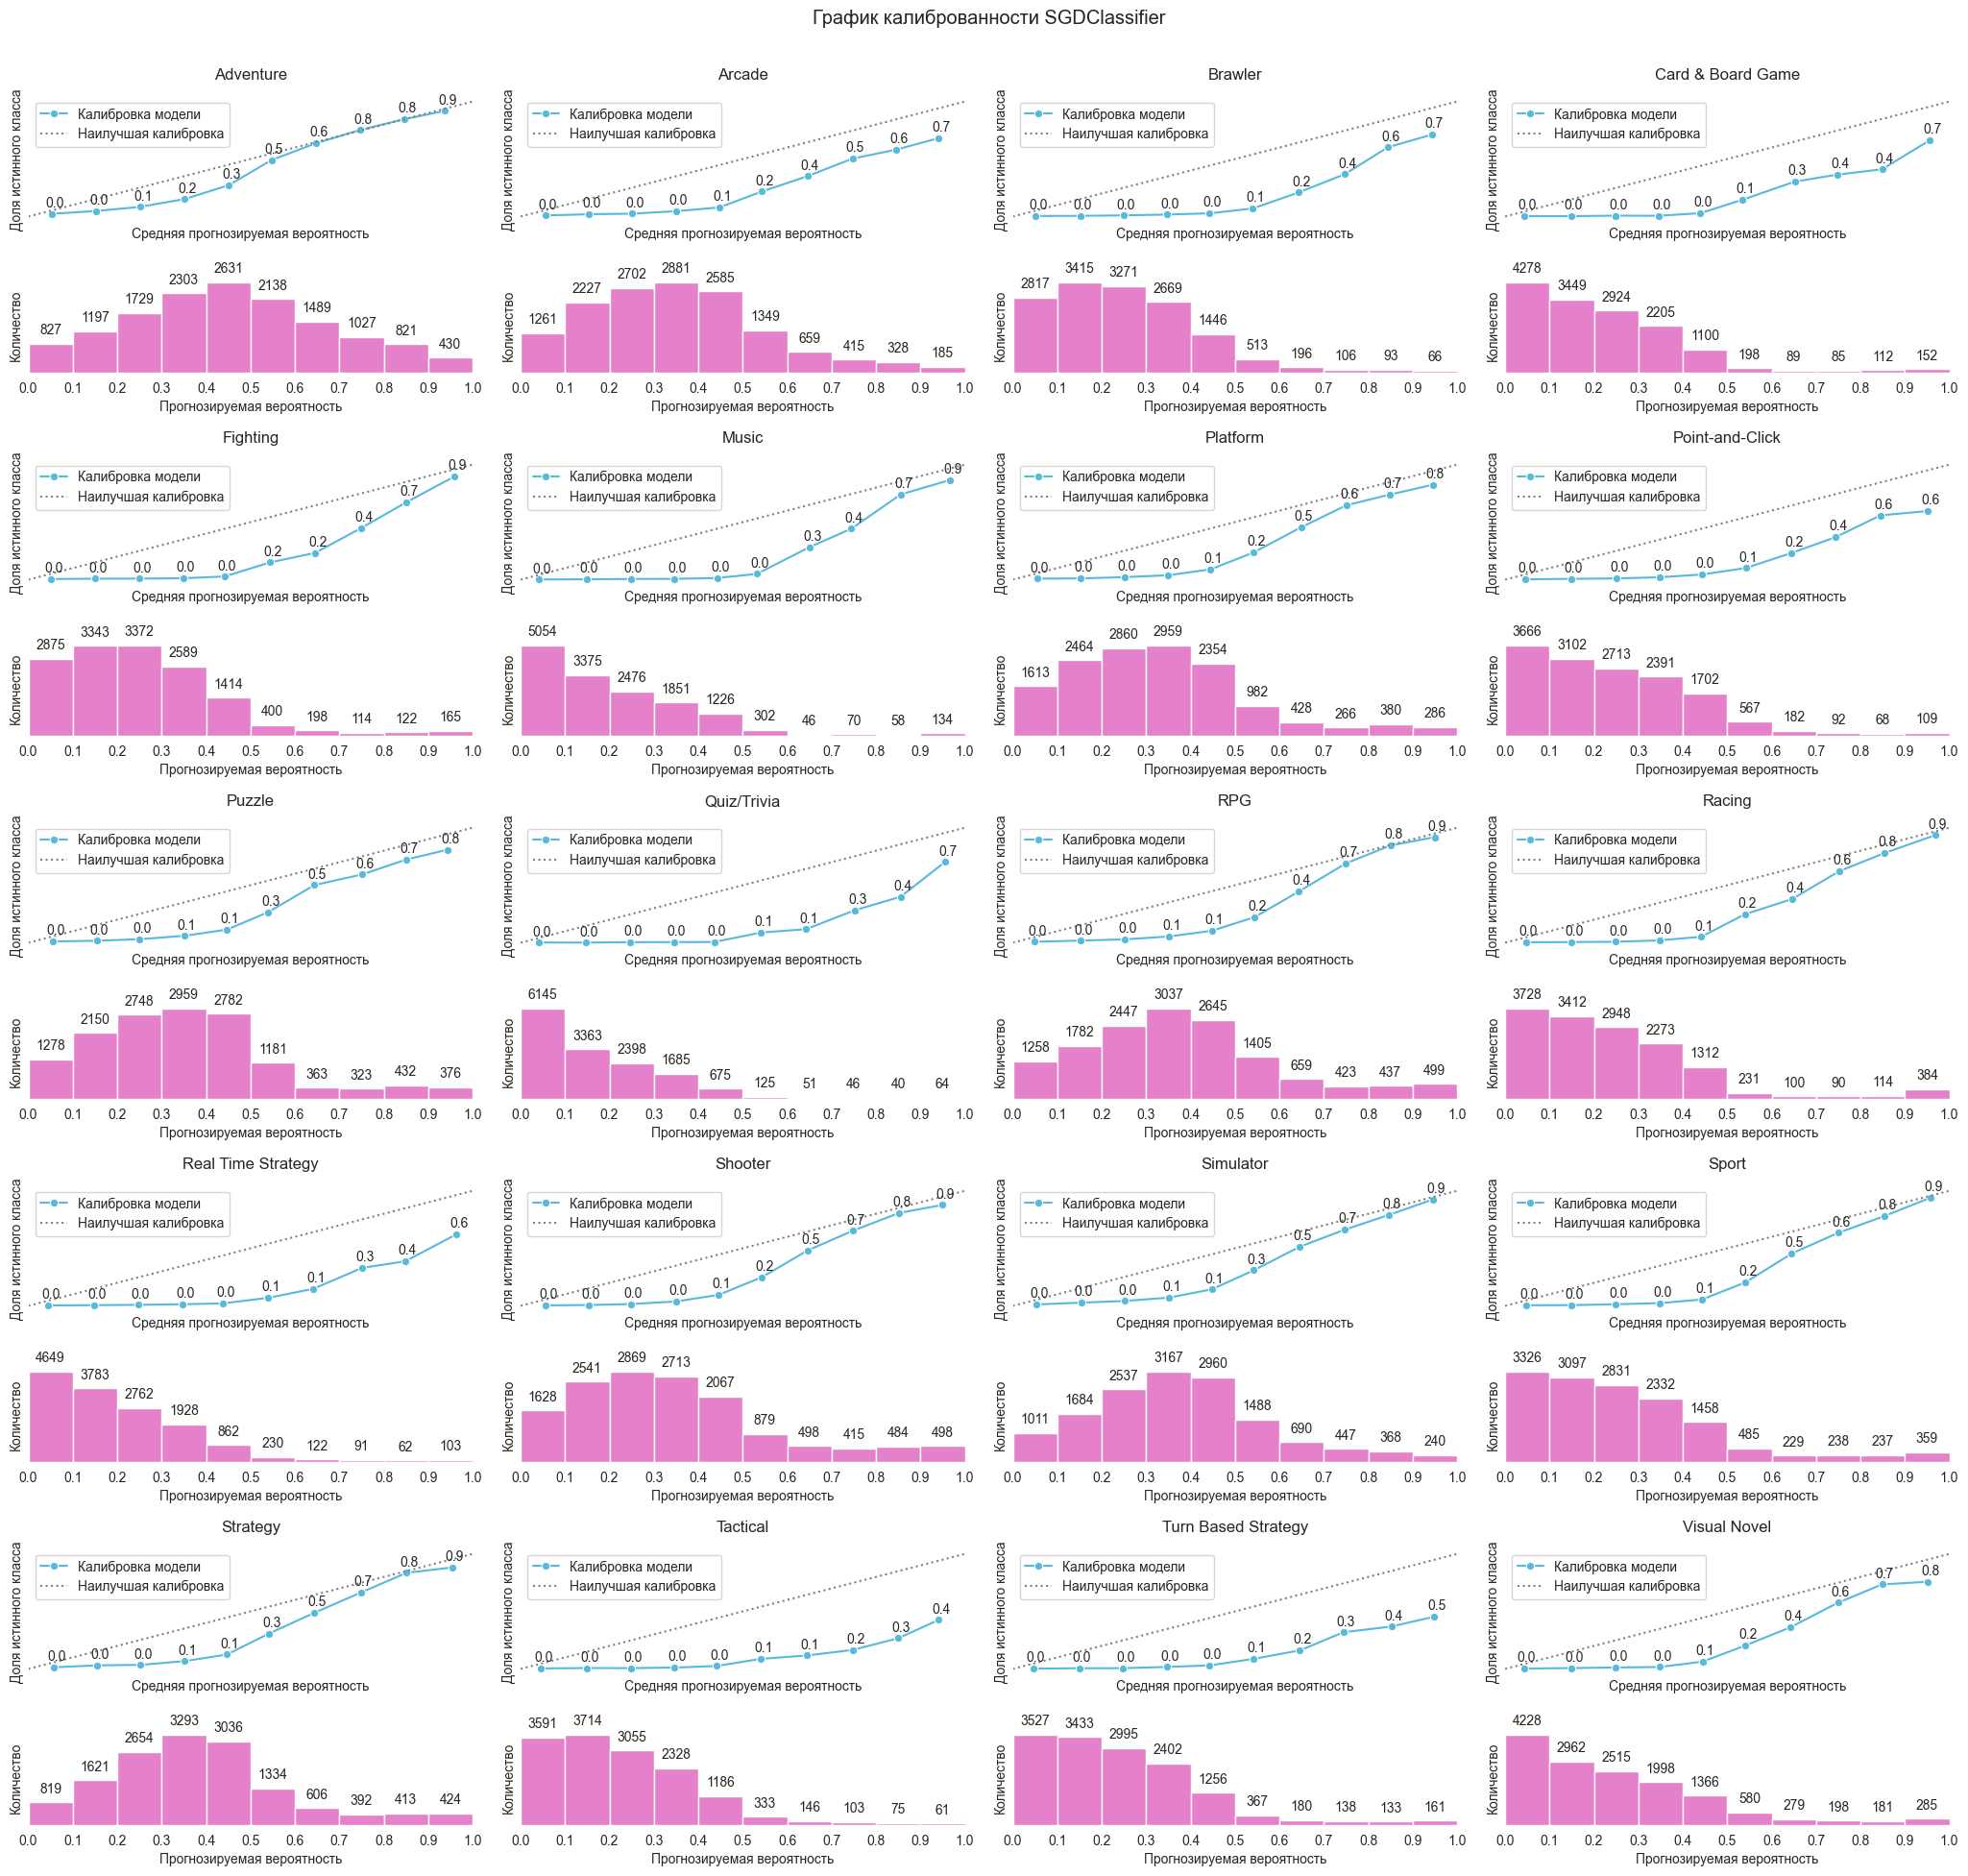

In [83]:
calibration.calibration(
    y_true=y_valid,
    y_proba=[pd.DataFrame(x) for x in predict_proba],
    labels=labels, 
    title='График калиброванности SGDClassifier'
)

### Выводы по тестированию моделей
***

1. Для стандартизации признаков использован **TfidfVectorizer**.
2. Дляля оценки эффективности **предсказательной способности** модели использована метрика **f1-weighted**.
3. Для **оценки эффективности** были выбраны следующие показатели:
    - время обучения;
    - время предсказания;
    - f1-weighted.
4. ComplementNB:
    - результаты кросс-валидации:
        - среднее время обучения: от **15** до **20** сек.;
        - среднее время предсказания: от **3** до **5** сек.;
        - среднее значение f1-weighted: **0.59**.
    - оценка масштабируемости:
        - кривые обучения показывают, что **присутствует** признак переобучения модели;
        - **добавление новых данных** возможно **улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
    - на валидационной выборке значение f1-weighted - **0.60**
    - калиброванность модели:
        - модель имеет **низкую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
        - прогнозируемая вероятность распределена **неравномерно**, приобладают значения в диапазонах от **0.0** до **0.1** и от **0.9** до **1.0**;
        - вероятнее всего, это связанос тем, что модель наивного байеса считает признаки независимыми;
        - **необходима** калибровка модели.  
5. SGDClassifier:
    - результаты кросс-валидации:
        - среднее время обучения: от **20** до **25** сек.;
        - среднее время предсказания:от **3** до **5** сек.;
        - среднее значение f1-weighted: **0.60**.
    - оценка масштабируемости:
        - кривые обучения показывают, что **присутствует** признак переобучения модели;
        - **добавление новых данных не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
    - на валидационной выборке значение f1-weighted - **0.60**
    - калиброванность модели:
        - модель имеет **неплохую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
        - прогнозируемая вероятность распределена **неравномерно**, тем не менее, **отсутствуют** явно приобладающие диапазоны;
        - для более точного прогнозирования вероятности **необходима** калибровка модели.

## Проверка модели на тестовой выборке
***

In [84]:
(results
 .style
 .format(lambda x: f'{x:.3f}'))

,Время обучения,Время предсказания,f1-weighted
ComplementNB,17.413,5.689,0.587
SGDClassifier,21.297,3.030,0.596


In [85]:
predict = sgd.predict(x_test)

In [86]:
f1 = f1_score(
    y_true=y_test,
    y_pred=predict,
    average='weighted'
)

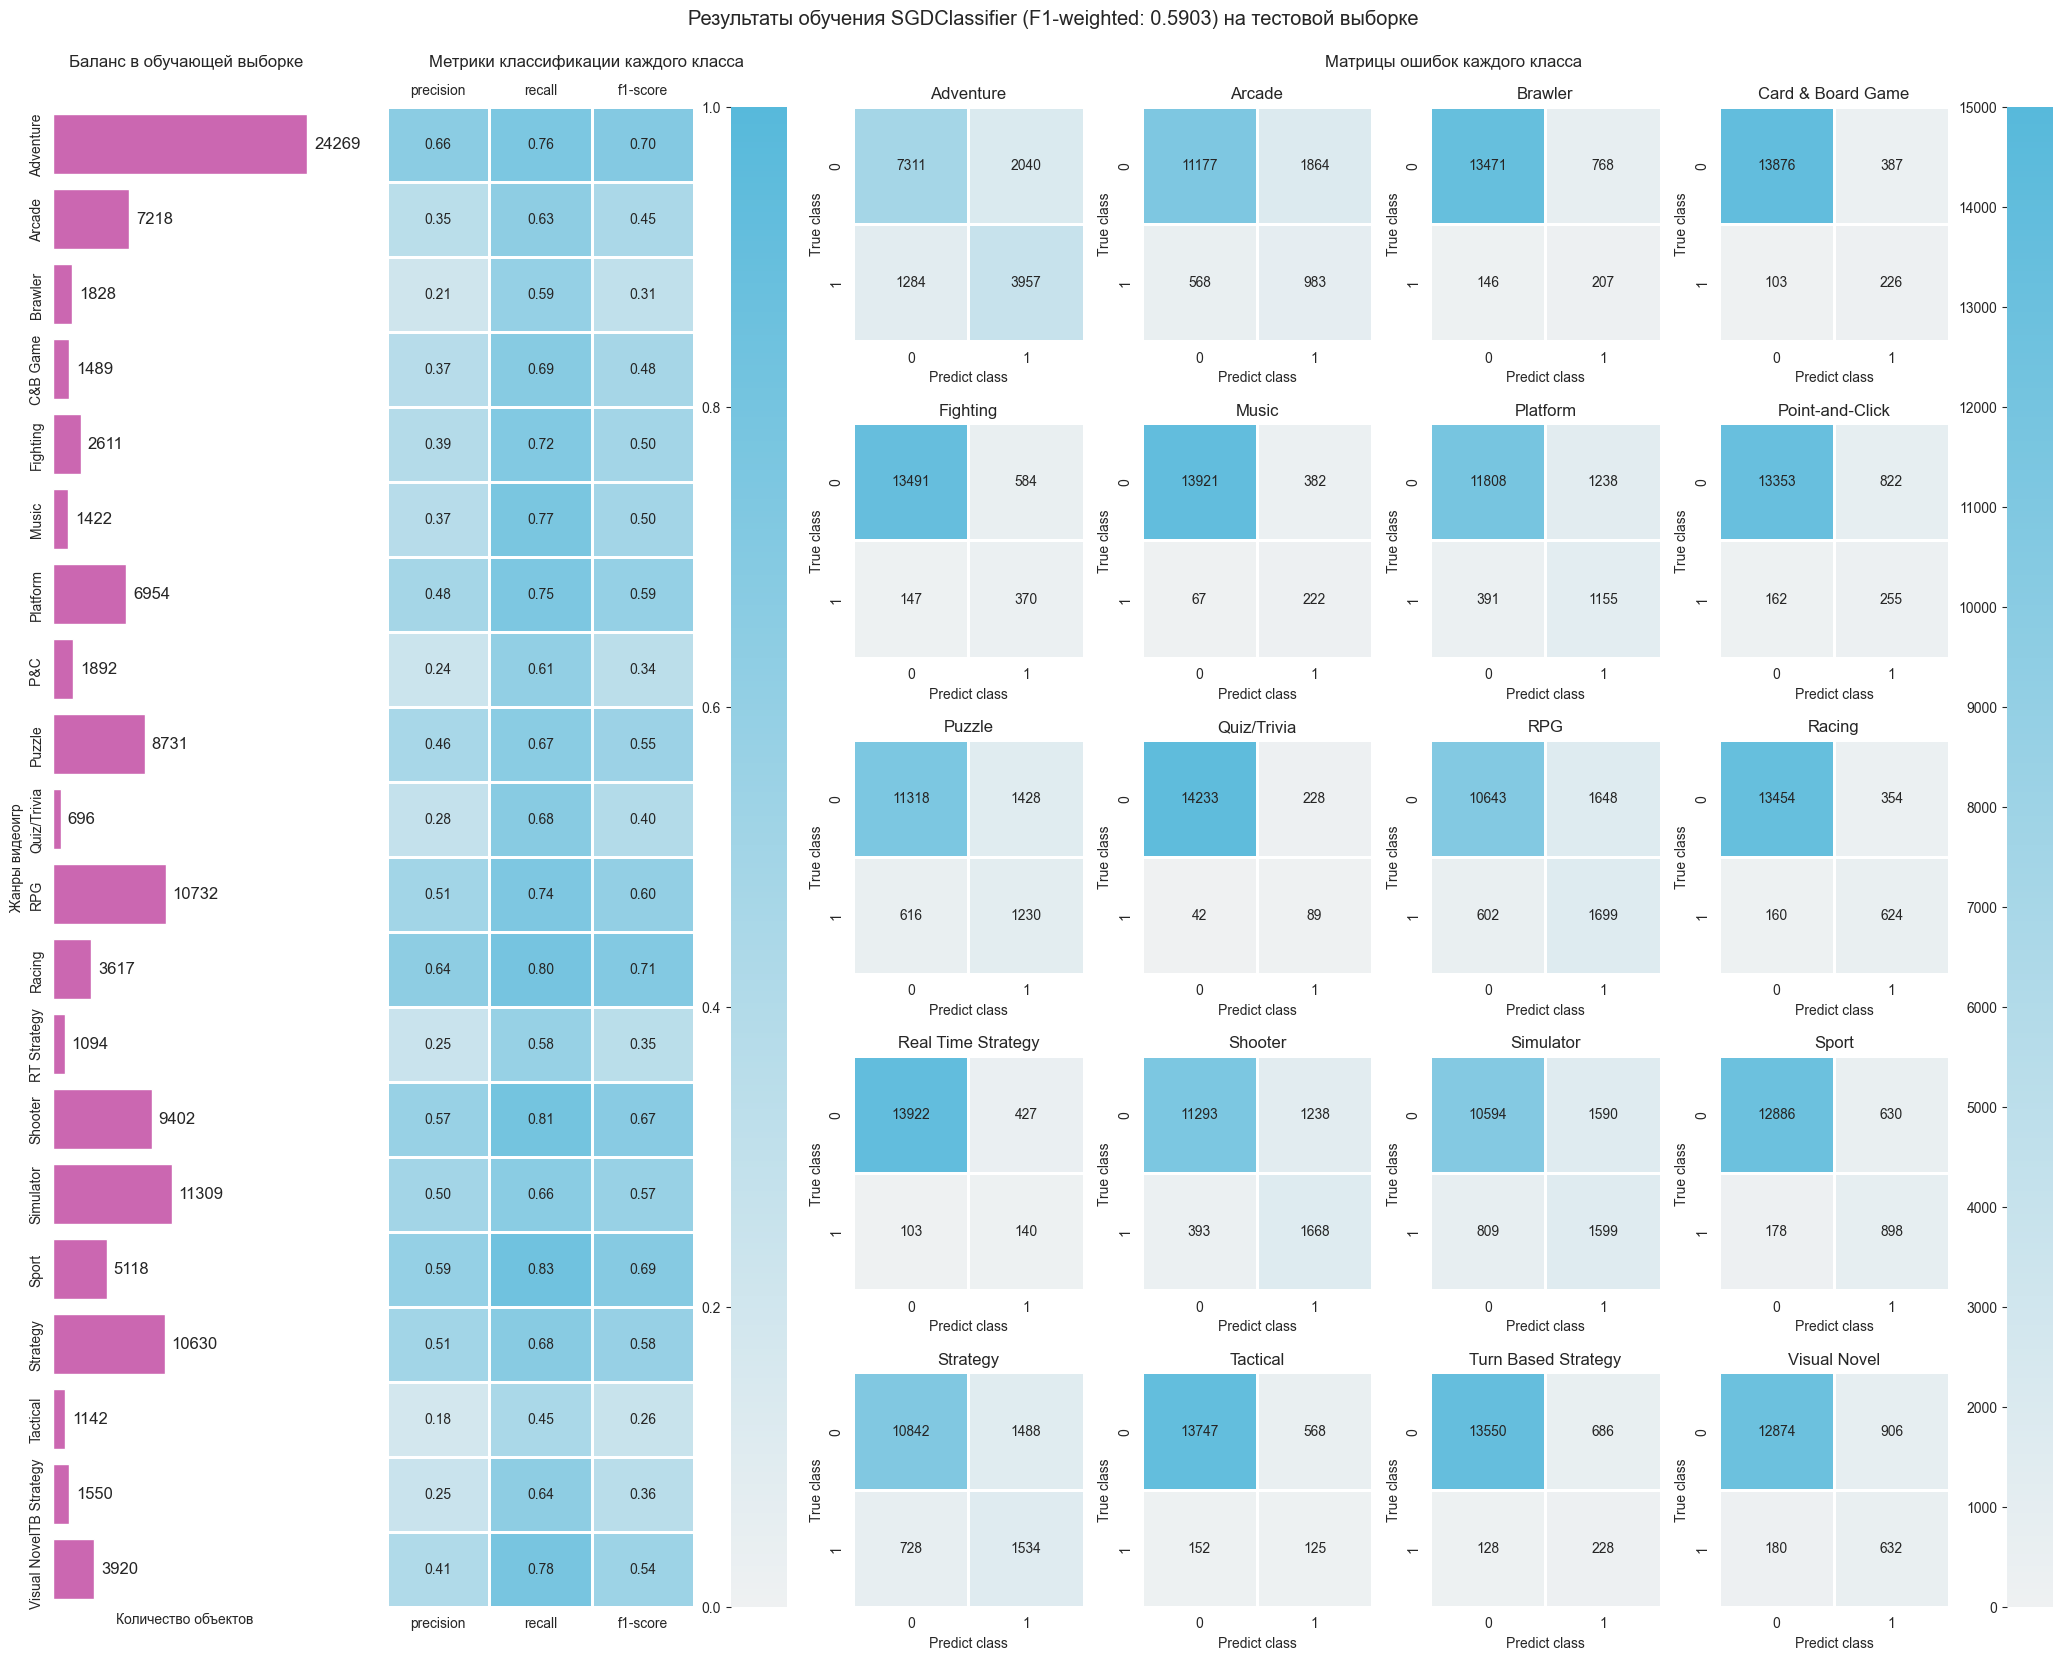

In [87]:
metrics.metrics(
    y_test=y_test,
    y_predict=pd.DataFrame(predict),
    y_train=y_train,
    title=f'Результаты обучения SGDClassifier '
          f'(F1-weighted: {f1:.4f}) на тестовой выборке',
    labels=labels
)

## Сравнение с простым классификатором 

In [88]:
dummy_clf = DummyClassifier(
    strategy='stratified',
    random_state=RANDOM_STATE
)
dummy_clf.fit(x_train, y_train)

DummyClassifier(random_state=42, strategy='stratified')

In [89]:
predict = pd.DataFrame(dummy_clf.predict(x_test))

In [90]:
f1 = f1_score(
    y_true=y_test,
    y_pred=predict,
    average='weighted'
)

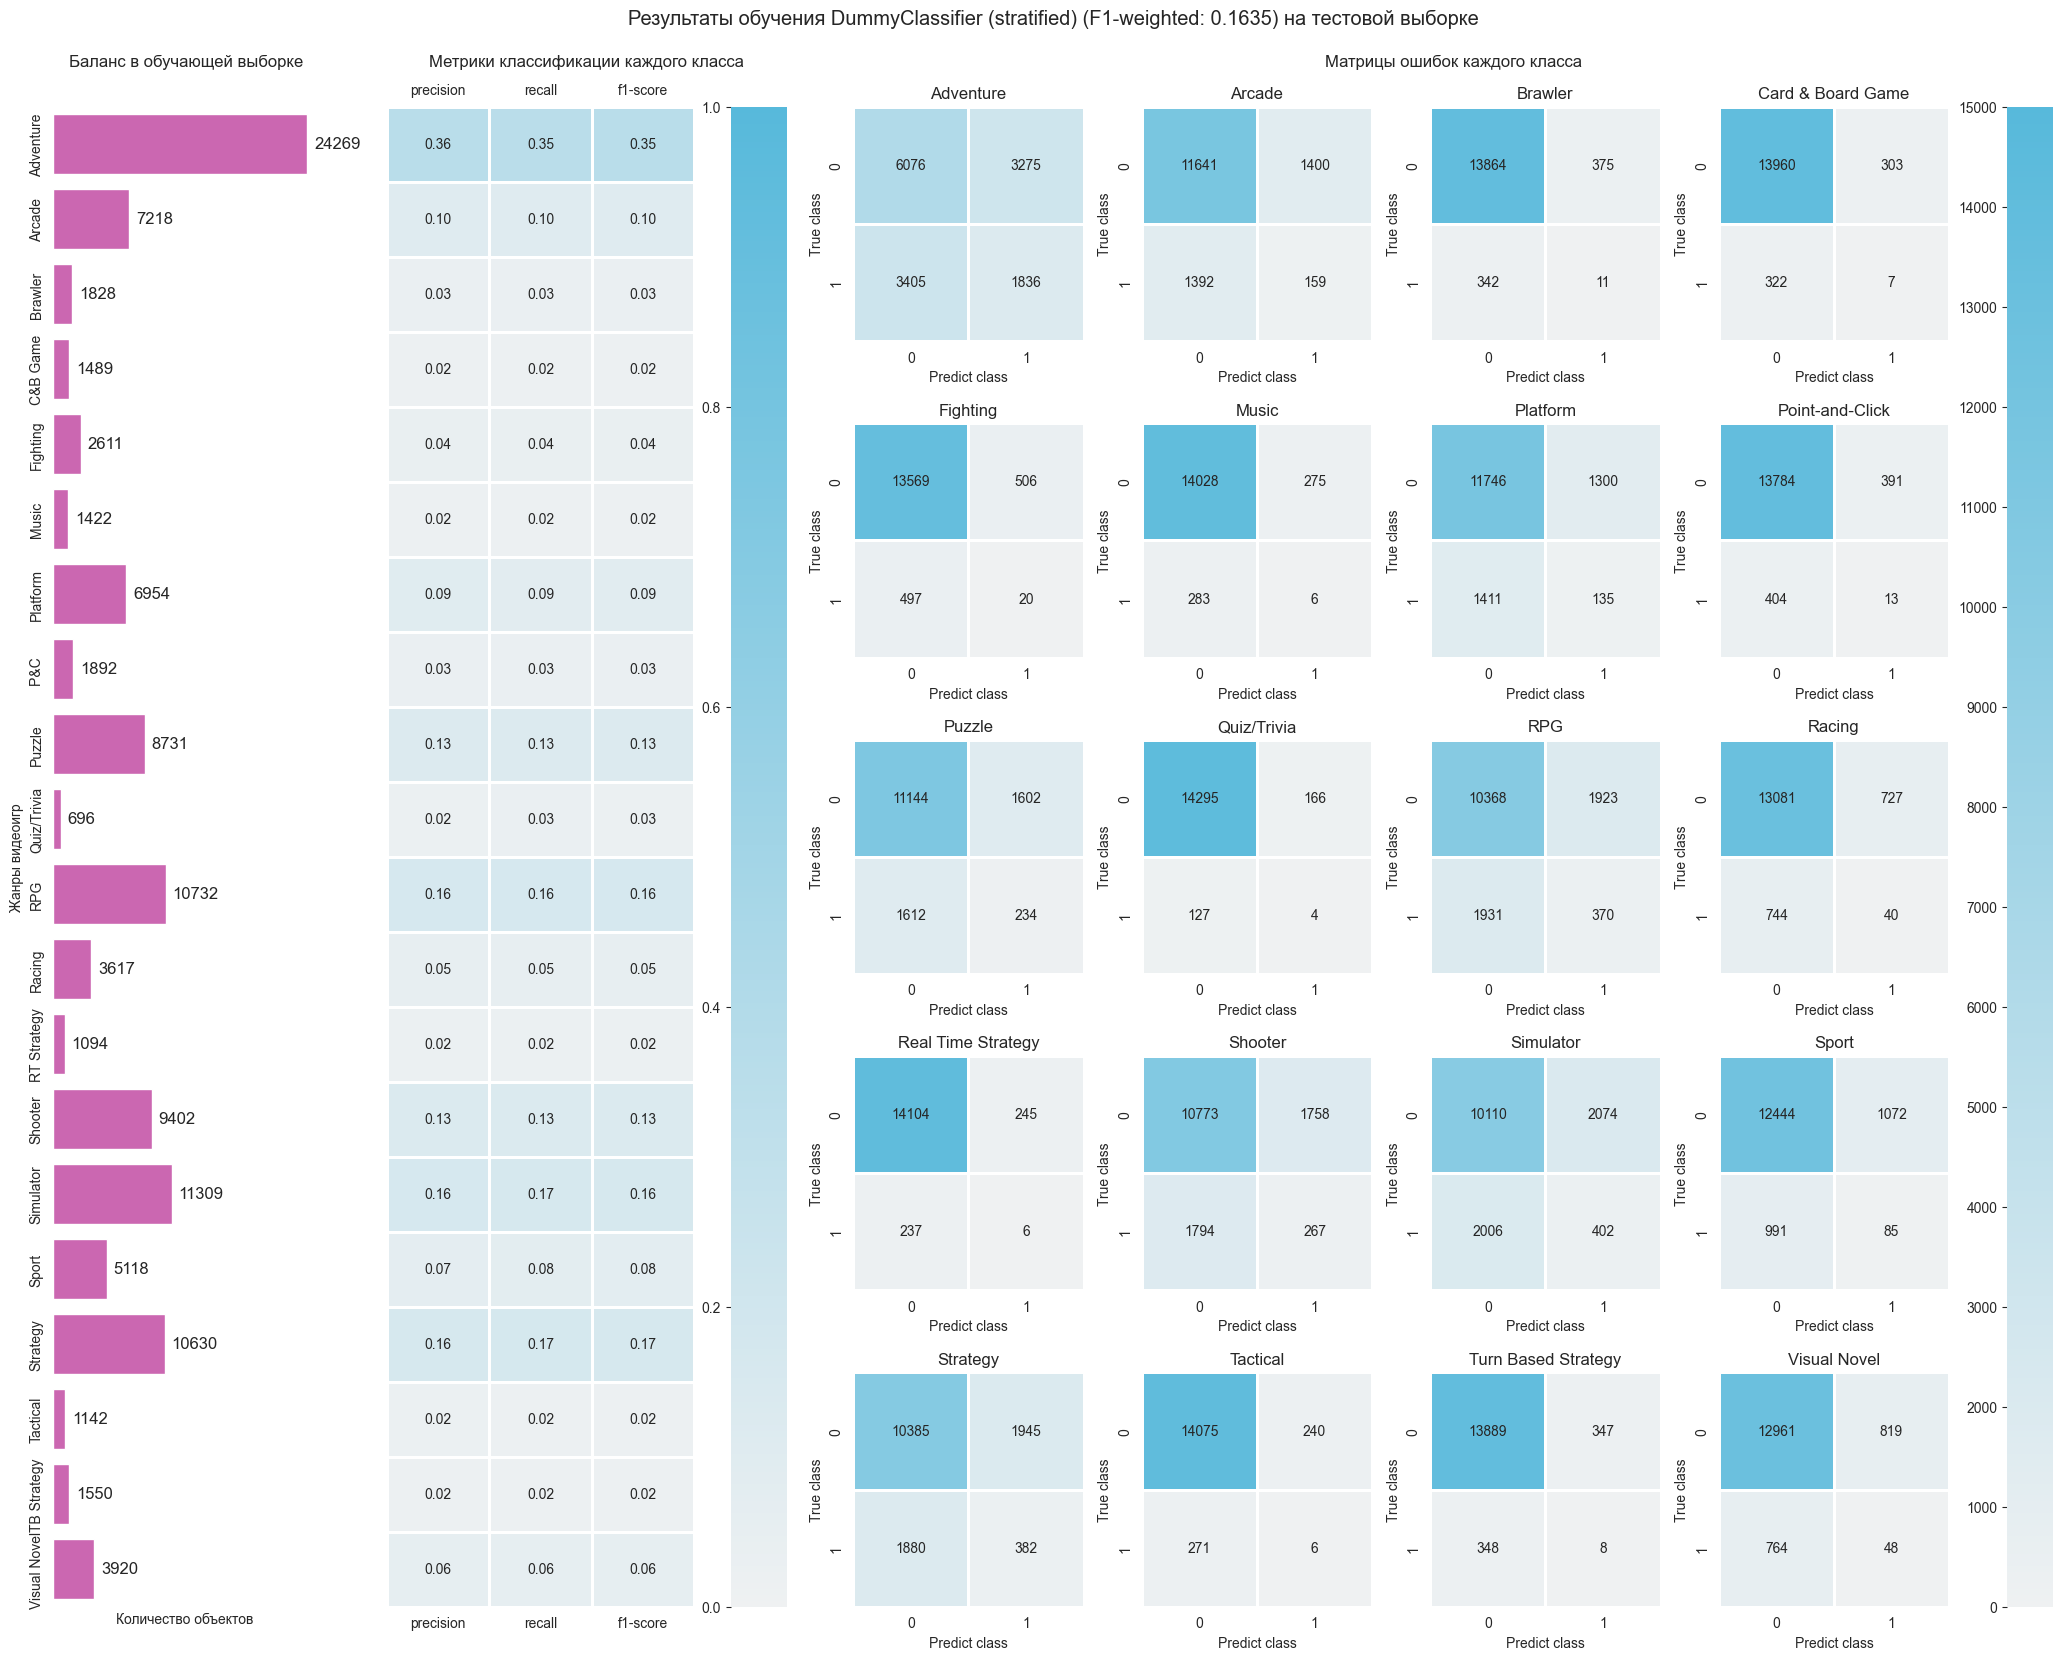

In [91]:
metrics.metrics(
    y_test=y_test,
    y_predict=pd.DataFrame(predict),
    y_train=y_train,
    title=f'Результаты обучения DummyClassifier (stratified) '
          f'(F1-weighted: {f1:.4f}) на тестовой выборке',
    labels=labels
)

# Выводы
***

1. Были отобраны описания видеоигр только с ascii символами.
2. Описания объеденены с **20 наиболее популярными** жанрами.
3. Предварительная обработка текста:
    - описание видеоигр **очищено** от символов, отличных от символов **латинского алфавита**.
    - проведена **лемматизация** текста.
    - **удалены** записи с описанием менее **100 символов**;
4. Данные поделены на **тренировочную**, **валидационную** и **тестовую** выборки в отношении **7:1.5:1.5**.
5. Анализ баланса классов:
    - в наборе данных **присутствует дисбаланс классов**;
    - **мажоритарным** классом является класс **Adventure** (количество экземпляров более **29 тыс.**);
    - **миноритарным** классом является класс **Quiz/Trivia** (количество экземпляров менее **1 тыс.**);
    - **остальные** классы имеют от **800** до **13 тыс.** экземпляров.
6. Частотный анализ:
    - наиболее часто в описаниях видеоигр встречается слово **game** (приблизительно **70 тыс.** раз);
    - **остальные слова** встречаются в описаниях видеоигр менее **20 тыс.** раз;
    - для каждого класса существует свой **уникальный** список наиболее часто встречающихся слов в описаниях видеоигр.
7. Тестирование моделей:
    - Для стандартизации признаков использован **TfidfVectorizer**.
    - Дляля оценки эффективности **предсказательной способности** модели использована метрика **f1-weighted**.
    - Для **оценки эффективности** были выбраны следующие показатели:
        - время обучения;
        - время предсказания;
        - f1-weighted.
    1. ComplementNB:
        - результаты кросс-валидации:
            - среднее время обучения: от **15** до **20** сек.;
            - среднее время предсказания: от **3** до **5** сек.;
            - среднее значение f1-weighted: **0.59**.
        - оценка масштабируемости:
            - кривые обучения показывают, что **присутствует** признак переобучения модели;
            - **добавление новых данных** возможно **улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
        - на валидационной выборке значение f1-weighted - **0.60**
        - калиброванность модели:
            - модель имеет **низкую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
            - прогнозируемая вероятность распределена **неравномерно**, приобладают значения в диапазонах от **0.0** до **0.1** и от **0.9** до **1.0**;
            - вероятнее всего, это связанос тем, что модель наивного байеса считает признаки независимыми;
            - **необходима** калибровка модели.  
    2. SGDClassifier:
        - результаты кросс-валидации:
            - среднее время обучения: от **20** до **25** сек.;
            - среднее время предсказания:от **3** до **5** сек.;
            - среднее значение f1-weighted: **0.60**.
        - оценка масштабируемости:
            - кривые обучения показывают, что **присутствует** признак переобучения модели;
            - **добавление новых данных не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
        - на валидационной выборке значение f1-weighted - **0.60**
        - калиброванность модели:
            - модель имеет **неплохую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
            - прогнозируемая вероятность распределена **неравномерно**, тем не менее, **отсутствуют** явно приобладающие диапазоны;
            - для более точного прогнозирования вероятности **необходима** калибровка модели.
8. Проверка модели на тестовой выборке:
    - выбрана модель **SGDClassifier**;
    - значение f1-weighted: **0.59**.
9. Сравнение с простым классификатором:
    - в качестве простого классификатора выбран **DummyClassifier (stratified)**;
    - значение f1-weighted: **0.16**